<table style="width: 100%;">
  <tr>
    <td style="text-align: left;"><h1 style="font-size: 30px;">Review of dataset</h1></td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>

# Data Analysis - Second Iteration - Summary

In this second iteration of our data analysis, our primary focus is to improve the performance of the Random Forest model that we previously developed. To achieve this, we will explore various aspects of our data and model. Here are the main areas we will be investigating:

## Areas of Focus

1. **Review Count Thresholds to train the RF** In previouse iterations I chose at random that I would only use accomodations with at least 100 reviews to improve consistency. Now I want to see if I can bring down this number in the spirit of having more training data without compromising the value of the data.

2. **Utilizing Full Location Variable:** We will consider the full location variable to assess whether it provides more valuable information for our model compared to a simplified or reduced representation.

3. **Incorporating Full Amenities Variables:** Instead of using Principal Component Analysis (PCA) on amenities, we will use the full amenities variables to evaluate if this leads to better model performance.

5. **Sentiment Analysis:** We will incorporate sentiment analysis of reviews as a feature to gauge its impact on the model's performance.

6. **GPT analysis** We will be performing prompt engeniering to extract better features from description. We will be using a package that allows us to use GPT without paying.

7. **Location Score Analysis:** We will delve deeper into the impact of location on our predictions. This includes examining how different location variables affect the model's performance.

8. **Outliar Analysis:** We will look into the values where the score is particularly low.

Additionally, we will create custom transformers to make the data processing process more seamless. These custom transformers will assist in efficiently preparing the data for model training and analysis.

Through these investigations, we aim to fine-tune our Random Forest model and improve its predictive accuracy. By considering a more detailed representation of location, amenities, and reviews, we expect to uncover valuable insights that will lead to better results.

Let's begin our exploration and analysis, making use of custom transformers to enhance our data processing workflow and streamline our efforts in enhancing our model's performance.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import re 
import seaborn as sns
from scipy import stats

# Eliminate warnings for presentation purpuses
import warnings
warnings.filterwarnings('ignore') #ignore all warnings, very messy
#warnings.filterwarnings('default')
pd.options.mode.chained_assignment = None
from rich import print

#preatty printing
from rich import print
from tabulate import tabulate
from IPython.display import Markdown
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', 100)
from prettytable import PrettyTable
import icecream as ic
import os

import shap
from sklearn.model_selection  import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### New Library

We are going to be using from now on llibrary model_1, that contains the following classes:
- DataPreProcess: This class contains the necessary functions to process the data to train your model
- ModelMaking: This class contains the necessary functions to train and show the results of the trained models

Here is an example

In [2]:
from model_1 import DataPreProcess, ModelMaking
import pandas as pd
from sklearn.model_selection import train_test_split


data_processer = DataPreProcess()
mod_maker = ModelMaking()

insights = pd.read_csv('bdd_barcelona/originals/listings.csv')
reviews = pd.read_csv('bdd_barcelona/originals/reviews.csv')

def filter_accomodation_num_review(bdd, col_name, min_reviews = 100):
    return bdd[bdd[col_name] >= min_reviews]

In [3]:
filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', 25)
A,B = data_processer.bdd_premodel(filtered_insights,"bdd_barcelona/AB/base_with_descrip",case = 1,recalculate = False)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

-----------------------------Model Found-----------------------------

,Model,Score type,R^2,MSE
0,RF >Latestrevi,review_scores_rating,0.526482,0.026407
1,RF >Latestrevi,review_scores_accuracy,0.477357,0.023137
2,RF >Latestrevi,review_scores_cleanliness,0.397730,0.038216
3,RF >Latestrevi,review_scores_checkin,0.619967,0.017541
4,RF >Latestrevi,review_scores_communication,0.517028,0.018429
5,RF >Latestrevi,review_scores_location,0.351028,0.019125
6,RF >Latestrevi,review_scores_value,0.527393,0.027208


----------------------------Model Loaded-----------------------------

RandomForestRegressor(random_state=0)

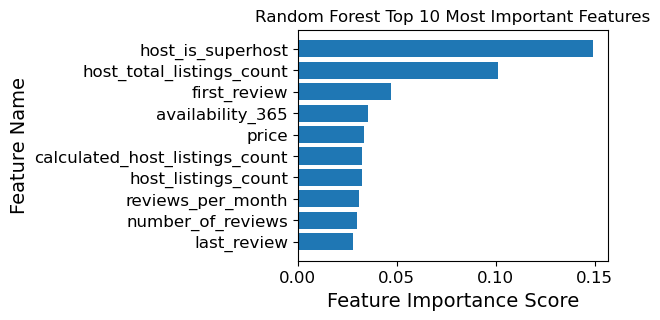

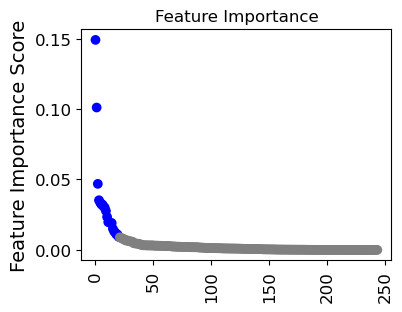

In [4]:
min_reviews = 25
sentiment = True
recalculate = False
filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', min_reviews)

# Train/load model
model,A,B,results_df = mod_maker.load_rf_model(filtered_insights,"Latest",recalculate)
display(model)

# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

#mod_maker.plot_all_results(y_test,y_pred_rf)
mod_maker.feature_importance(X_train,model)

# Feature engeniering

## SENTIMENT ANALYSIS

### Calculations

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
min_reviews = 25
#reviews = pd.read_csv('bdd_barcelona/originals/reviews.csv')
reviews = pd.read_csv('bdd_barcelona/processed/Test-5/reviews_with_sentiment.csv')

# Create a new column for sentiment
if 'sentiment' not in list(reviews.columns):
    print("--------------------------------SENTIMENT ANALYSIS: START----------------------------------")
    # Fill the empty comments with "empty"
    reviews["comments"] = reviews["comments"].fillna("empty")
    reviews["sentiment"] = reviews["comments"].apply(lambda review: SentimentIntensityAnalyzer().polarity_scores(review)["compound"])
    print("--------------------------------SENTIMENT ANALYSIS: FINISHED----------------------------------")
    reviews.to_csv("reviews_with_sentiment.csv", index=False)
else:
    print("--------------------------------SENTIMENT ANALYSIS: DONE----------------------------------")

--------------------------------SENTIMENT ANALYSIS: DONE----------------------------------

In [13]:
# Identify the most positive reviews
df_positive = reviews[reviews["sentiment"] > 0.5]

# Identify the most negative reviews
df_negative = reviews[reviews["sentiment"] < -0.5]

# Print the most positive and negative reviews
print("Most positive reviews:")
display(df_positive.iloc[:10, :])

print("Most negative reviews:")
display(df_negative.iloc[:10, :])

Most positive reviews:

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,18674,4808211,2013-05-27,4841196,Caron,"Great location. Clean, spacious flat. Would recommend to anyone.",0.8519
2,18674,41087522,2015-08-04,35231385,Shlomi,"Big apartment, well equipped.\r<br/>Very good service, excellent location.\r<br/>Recommended.",0.8271
3,18674,81000756,2016-06-20,23223644,Joost,"The Check in was fast and flexible. The price is fair, because the flat ist big enough for 8 peo...",0.9252
4,18674,278588962,2018-06-18,4756672,Marius,Great location and enough space in the apartment for 7 people. Although the mattresses were a bi...,0.5729
6,18674,434013302,2019-04-07,23884550,Desirée,Super fast and easy check-in and very friendly service. The price is fair and the apartment has ...,0.9633
8,41952,1303798,2012-05-19,2154789,Armaz,We visited with our 2 small kids BCN for a week and spent a great time in Teresa's APT. All Desc...,0.8974
9,18674,437816369,2019-04-15,12182090,Kevin,Amazing flat at a great location in Central Barcelona. Will definitely​ recommend.,0.8860
11,18674,445984236,2019-04-30,124386486,Mihail,Great location and nice apartment.,0.7845
15,18674,463457868,2019-06-03,133074241,Jon,Great Location with a lovely morning view of the Segrada Família. Anna from Barcelona4seasons wa...,0.9364
16,18674,480168541,2019-07-02,13969136,Burc,"Nice place next to sagrada , a bit far from downtown and the beaches tough. Kitchen facilities a...",0.8458


Most negative reviews:

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
101,41952,749820275993858859,2022-10-31,276088326,Ina,I don't like to write negative reviews but I really can't recommend this Airbnb and I don't want...,-0.9916
102,41952,851250801419001849,2023-03-20,47376857,Angelika,Wohnung im 3. Stock mit Aufzug in Top-Lage in Fußnähe zur Sagrada Familia und den U- Bahnen L2 u...,-0.8316
138,23197,200448257,2017-10-05,151833917,Jose Luis,"El apartamento es tal como se describe. Muy cómodo, con una gran terraza, todo el menaje necesar...",-0.5574
148,23197,365455559,2019-01-01,220992441,Rafael,"El departamento cuenta con todo lo necesario para 6 personas.<br/>La ubicación es excelente, ta...",-0.8020
165,49968,226964954,2018-01-13,41601154,Nerea,La casa está muy bien ubicada y es fácil moverse tanto en transporte público como caminando a cu...,-0.5267
231,49968,665744832897796184,2022-07-07,163417914,Mónica,El apartamento está estupendamente ubicado para desplazarte y conocer la ciudad sin problemas. E...,-0.5574
257,32711,3654789,2013-02-28,5001874,Manfred,Ich war zusammen mit einem Kollegen während des Mobile World Congress in Barcellona drei Tage in...,-0.9136
305,68547,74058713,2016-05-12,41653828,Katharina,Atùn ist ein sehr sympathischer Gastgeber. Er hat sich total nett um uns gekümmert und uns mit g...,-0.8650
345,68547,256573167,2018-04-23,210284,Beate,"SUPER-Lage, Bus und U-Bahn um die Ecke, Fahrradverleih ebenfalls, so dass man wirklich schnell ü...",-0.9246
421,32711,719355718037088876,2022-09-19,461687947,Luis,Nick war ein sehr freundlicher und aufmerksamer Gastgeber.<br/>Die Wohnung war in sehr guter Lag...,-0.8316


In [163]:
def sentiment_analysis_to_insight():
    #if 'average_value_per_listing_id' not in sentlist(bdd.columns):
    # ---------------------- ADD SENTIMENT AVERAGE TO EVERY ACCOMODATION------------------------------------------------
    filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', 1)
    new_insight = filtered_insights.loc[:, ['id','number_of_reviews']]
    new_reviews = reviews.loc[:, ['listing_id', 'sentiment']]
    new_reviews.rename(columns={'listing_id': 'id'},inplace=True)

    grouped_df = new_reviews.merge(new_insight, on="id").groupby("id")
    average_value_per_listing_id = grouped_df["sentiment"].mean()
    filtered_insights["average_value_per_listing_id"] = filtered_insights["id"].apply(lambda i: average_value_per_listing_id[i])


    # ----------------------ADD TOP 5 BEST AND WORST COMMENTS FOR EVERY ACCOMODATION --------------------------------
    df = new_reviews.merge(new_insight, on="id")
    df['rank'] = df.groupby('id')['sentiment'].rank(ascending=True)
    df['pos'] = df['number_of_reviews']-df['rank'] + 1
    df = df[(df['pos'] <= 5) | (df['rank'] <= 5)]
    top_10_df = pd.DataFrame(index=df['id'].unique())
    for i in range(1, 6):
        top_10_df[f'sent{i}'] = df[df['rank'] == i].groupby('id')['sentiment'].mean()

    for i in range(1, 6): 
        top_10_df[f'sent{5+i}'] = df[df['pos'] == 6-i].groupby('id')['sentiment'].mean()
    df = df.drop(columns=['rank'])
    top_10_df.fillna(0, inplace=True)

    filtered_insights = filtered_insights.merge(top_10_df, left_on='id', right_index=True)


    # ----------------------ADD TOP 5 BEST AND WORST AVERAGE --------------------------------
    display(merged_df.head(1))
    # Save the `insight` DataFrame with the new column
    merged_df.to_csv("bdd_barcelona/processed/Test-5/insight_with_sentiment.csv", index=False)


In [164]:
sentiment_analysis_to_insight()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,sent1,sent2,sent3,sent4,sent5,sent6,sent7,sent8,sent9,sent10
0,18674,https://www.airbnb.com/rooms/18674,20230610001920,2023-06-10,city scrape,Rental unit in Barcelona · ★4.35 · 3 bedrooms · 6 beds · 2 baths,"110m2 apartment to rent in Barcelona. Located in the Eixample district, near the Sagrada Familia...","Apartment in Barcelona located in the heart of Eixample district, within only 150 m form the gre...",https://a0.muscache.com/pictures/13031453/413cdbfc_original.jpg,71615,...,-0.3284,-0.296,-0.0333,0.0,0.0,0.9403,0.9574,0.9633,0.9801,0.9943


### Results

-----------------------------Model Found-----------------------------

,Model,Score type,R^2,MSE
0,RF >Sentiment_50_fullrevi,review_scores_rating,0.584125,0.019105
1,RF >Sentiment_50_fullrevi,review_scores_accuracy,0.508593,0.015860
2,RF >Sentiment_50_fullrevi,review_scores_cleanliness,0.370311,0.029930
3,RF >Sentiment_50_fullrevi,review_scores_checkin,0.641084,0.012788
4,RF >Sentiment_50_fullrevi,review_scores_communication,0.588484,0.011620
5,RF >Sentiment_50_fullrevi,review_scores_location,0.358183,0.016241
6,RF >Sentiment_50_fullrevi,review_scores_value,0.568763,0.017267


----------------------------Model Loaded-----------------------------

RandomForestRegressor(random_state=0)

Thise are the results of adding the following attributes:
          - sentiment = average sentiment of all reviews
          - sent1-....-sent10 = top 5 and worst sentiment of reviews

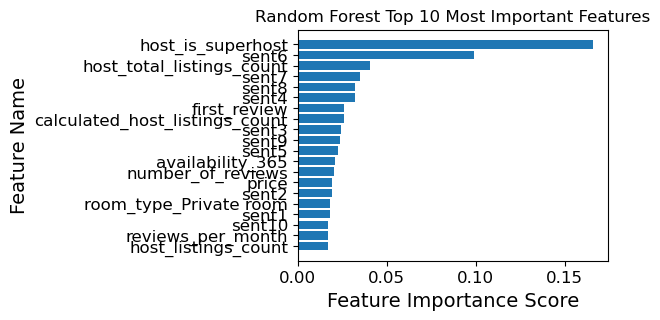

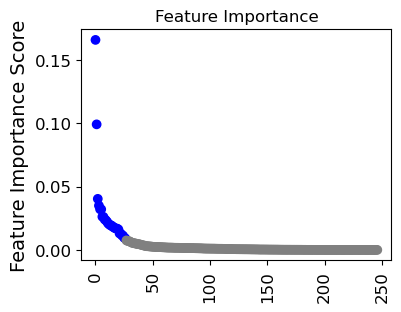

In [15]:
insights_with_sentiment = pd.read_csv('bdd_barcelona/processed/Test-5/insight_with_sentiment.csv')

min_reviews = 50
sentiment = True
recalculate = False

filtered_insights = filter_accomodation_num_review(insights_with_sentiment, 'number_of_reviews', min_reviews)

# Train/load model
model,A,B,results_df = mod_maker.load_rf_model(filtered_insights,"Sentiment_50_full",recalculate)
display(model)

# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

print("""Thise are the results of adding the following attributes:
          - sentiment = average sentiment of all reviews
          - sent1-....-sent10 = top 5 and worst sentiment of reviews""")

#mod_maker.plot_all_results(y_test,y_pred_rf)
mod_maker.feature_importance(X_train,model)

In [13]:
insights_with_sentiment = pd.read_csv('bdd_barcelona/processed/Test-5/insight_with_sentiment.csv')

min_reviews = 50
sentiment = True
recalculate = False

filtered_insights = filter_accomodation_num_review(insights_with_sentiment, 'number_of_reviews', min_reviews)

col_names = ['sent1','sent2','sent3','sent4','sent5','sent6','sent7','sent8','sent9','sent10']
columns_to_drop = [col for col in col_names if col in filtered_insights.columns]
filtered_insights.drop(columns=columns_to_drop, inplace=True)

# Train/load model
model,A,B,results_df = mod_maker.load_rf_model(filtered_insights,"Sentiment_50",recalculate)
display(model)

# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

print("""Thise are the results of adding the following attributes:
          - sentiment = average sentiment of all reviews""")

-----------------------------Model Found-----------------------------

,Model,Score type,R^2,MSE
0,RF >Sentiment_50revi,review_scores_rating,0.535640,0.021333
1,RF >Sentiment_50revi,review_scores_accuracy,0.462406,0.017351
2,RF >Sentiment_50revi,review_scores_cleanliness,0.379214,0.029507
3,RF >Sentiment_50revi,review_scores_checkin,0.637857,0.012903
4,RF >Sentiment_50revi,review_scores_communication,0.548020,0.012763
5,RF >Sentiment_50revi,review_scores_location,0.388336,0.015478
6,RF >Sentiment_50revi,review_scores_value,0.529024,0.018858


----------------------------Model Loaded-----------------------------

RandomForestRegressor(random_state=0)

Thise are the results of adding the following attributes:
          - sentiment = average sentiment of all reviews

## GPT Analysis

In [19]:
#pip install g4f
import g4f

g4f.debug.logging = True  # Enable logging
g4f.check_version = False  # Disable automatic version checking
print(g4f.version)  # Check version
print(g4f.Provider.Ails.params)  # Supported args

New pypi version: 0.1.9.8 (current: 0.1.8.2) | pip install -U g4f


0.1.8.2

g4f.provider.Ails supports: (model: str, messages: list[dict], stream: bool, temperature: float)

In [20]:
def ask_GPT(prompt,constrains):
    response = g4f.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": f"{prompt} (start your response with ::: {constrains})"}],
        stream=True,
    )
    introdution = ""
    # Save everything from the response after ::: into a variable
    for message in response:
        if message.startswith(":::") and len(introdution) == 0:
            introdution = message[3:]
        else:
            introdution += message
        
    return introdution[3:]

### Extract Dimension

In [21]:
def dimensions_prompt(description):
    intro = """Extract the total size of the accommodation in square meters from the given description and output only the number."""
    return f"{intro} {description}"

def extract_number_size(input_string):
    if input_string[:4] == "-3.5":
        input_string = input_string[4:]
    pattern = r'\d+'
    numbers = re.findall(pattern, input_string)
    if numbers:
        return int(numbers[0])
    else:
        return 0

def dimension(des_list):
    constrains = "and only ouput the number after it. If no dimensions is explicited, return 0"
    dimensions = []
    for i in des_list:
        intro = ask_GPT(dimensions_prompt(i),constrains)
        dimensions.append(intro)
    print(dimensions)
    results=[]
    for i in dimensions:
        results.append(extract_number_size(i))
    res = pd.DataFrame(results,columns=['size'])
    return res

### Extract Capacity

In [22]:
def capacity_prompt(des):
    intro = """Extract the maximum capacity from the accommodation description. Return only the number. If no information is found, return -1."""
    return f"{intro} {des}"

def extract_number_capacity(input_string):
    if input_string[:4] == "-3.5":
        input_string = input_string[4:]
    pattern = r'\d+'
    numbers = re.findall(pattern, input_string)
    if numbers:
        return int(numbers[0])
    else:
        return 0

def capacity(des_list):
    constrains = "AND ONLY OUTPUT THE NUMBER AFTER IT. If no capcity is explicited, return 0"
    results = []
    for i in des_list:
        intro = ask_GPT(capacity_prompt(i),constrains)
        results.append(intro)
    print(results)
    results2 = []
    for i in results:
        results2.append(extract_number_capacity(i))
    res = pd.DataFrame(results2,columns=['capacity'])
    return res

### Extract Target

In [23]:
def targuet_under_25_promt(des):
    intro = prompt = """
Given an accommodation description, analyze whether it mentions any restrictions or recommendations regarding young people, especially those under 25 years old. Assign a score of:

- `-1` if the description explicitly prohibits or strongly discourages groups of young people, particularly those under 25 years old.
- `0` if the description does not provide any information about age restrictions for guests.
- `1` if you believe the accommodation is suitable for young people, including those under 25 years old.

Please provide the appropriate score based on your analysis of the given accommodation description.
"""

    return f"{intro} {des}"

def extract_number(input_string):
    pattern = r'-?\d+'  # Include an optional minus sign in the pattern
    numbers = re.findall(pattern, input_string)
    
    for num_str in numbers:
        extracted_number = int(num_str)
        if extracted_number in [-1, 0, 1]:
            return extracted_number
    
    return 0

def targuet_under_25(des_list):
    constrains = "AND ONLY OUTPUT THE NUMBER AFTER IT. If no targuet is explicited, return 0"
    results = []
    for i in des_list:
        intro = ask_GPT(targuet_under_25_promt(i),constrains)
        results.append(intro)
    print(results)
    results2 = []
    for i in results:
        results2.append(extract_number(i))
    res = pd.DataFrame(results2,columns=["alowed_under_25"])
    return res

In [24]:
def targuet_families_promt(des):
    intro = prompt = """
Given an accommodation description, analyze whether it mentions any restrictions or recommendations regarding familys. Assign a score of:

- `-1` if the description explicitly prohibits or strongly discourages families.
- `0` if the description does not provide any information about families.
- `1` if you believe the accommodation is suitable for families, you may also include babis

Please provide the appropriate score based on your analysis of the given accommodation description.
"""

    return f"{intro} {des}"

def extract_number(input_string):
    pattern = r'-?\d+'  # Include an optional minus sign in the pattern
    numbers = re.findall(pattern, input_string)
    
    for num_str in numbers:
        extracted_number = int(num_str)
        if extracted_number in [-1, 0, 1]:
            return extracted_number
    
    return 0

def targuet_family_friendly(des_list):
    constrains = "AND ONLY OUTPUT THE NUMBER AFTER IT. If no targuet is explicited, return 0"
    results = []
    for i in des_list:
        intro = ask_GPT(targuet_families_promt(i),constrains)
        results.append(intro)
    print(results)
    results2 = []
    for i in results:
        results2.append(extract_number(i))
    res = pd.DataFrame(results2,columns=["family_friendly"])
    return res

In [39]:
descri1 = """110m2 apartment to rent in Barcelona. Located in the Eixample district, near the Sagrada Familia. It has a small balcony where you can see the temple of Gaudi. Capacity for 8 people. <br /><br />Licence number: HUTB-002062<br /><br /><b>The space</b><br />Apartment with 110 m2 located in the 6th floor in a building with elevator<br /><br />Huge living/dinig-room <br />1 double bedrrom <br />1 bedroom with 2 single beds <br />1 bedroom with bunk beds <br />Kitchen fully equipped for 8 people <br />1 bathroom with bathtub <br />1 small bathroom with shower <br />balcony <br /><br />The accommodation has been recently renovated and tastefully decorated  with a comfortable furniture and wood floor. Also it is equipped with heating, air conditioning and wifi.<br /><br /><b>Guest access</b><br />Free Wifi - air conditioning.<br /><br />We will provide basic amenities like shower gel, shampoo,and hand soap. Also, 1 set of bed linen and towels per person will be included.<br /><br /><b>License
"""
descri2 = """Beautiful spacious apartment, large terrace, 5 minutes walk from the CCIB center, sea, Port Forum.<br />Excellent location to combine business with pleasure, ideal for families<br />Relax on the large terrace for a quiet dinner or a nice glass of wine or cold beer away from the hustle and bustle of the center of Barcelona and the tourist crowds.<br />Groups of young people under 25 are not accepted, the apartment is not suitable for you.<br /><br /><b>The space</b><br />The stylish spacious apartment is suitable for 5 people but can sleep 6, please take note of the bed sizes!<br />Spacious living/dining room with air conditioning, floor to ceiling sliding glass doors opening onto a large balcony with dining table and chairs, and wicker sofa.<br />Master bedroom with bathroom en suite. ceiling fan, bed 150 x 200.<br />Bedroom with  large single bed,  ceililng fan , bed 120 x 190<br />Bedroom, two single beds, ceiling fan. beds 90 x 200 <br />Guest bathroom: walk-in shower, sink, bidet, 
"""
descri3 = """12 apartments of 45 to 57m2  situated between 1st and 3th floor. All of them have the same characteristics: 1 bedroom, 1 bathroom and living room-kitchen but different decorations and not all are included in the gallery, although they have the same guarantee.<br /><br />Modern apartments located in front of the beach and in one of the avant-garde neighborhoods, Poblenou<br /><br />Nearby construction in progress.<br /><br />HUTB-000171/000172/000182/011441/000173/006299/002917/005109/ 005102/010969 /005112/005100/010972<br /><br /><b>The space</b><br />The contemporary design of Lugaris Beach apartments features floor-to-ceiling windows, free high-speed internet access and a private kitchen with an oven, Nespresso coffee machine and fridge. They also include a living room, with flat-screen TV with international channels, a washing machine and a dryer. You will find a welcome pack with basic products like coffee, tea, milk, sugar, salt and oil. In addition to a bottle of mineral water.<
"""
#print(descri1)
#print("-----------------------------------")
#print(descri2)
#print("-----------------------------------")
#print(descri3)
#descriptions = [descri1,descri2,descri3]

In [11]:
def prova1(descriptions):
    res_dimension = dimension(descriptions)
    res_capacity = capacity(descriptions)
    res_under_25 = targuet_under_25(descriptions)
    res_family = targuet_family_friendly(descriptions)
    results_df1 = pd.concat([res_dimension, res_capacity, res_under_25, res_family], axis=1)
    return results_df1

In [12]:
#display(results_df1)

### Use on insight description

In [11]:
from datetime import datetime
import sys
import os

In [12]:
# Function to temporarily suppress printing
def silent_execution(func):
    def wrapper(*args, **kwargs):
        # Redirect stdout to suppress printing
        original_stdout = sys.stdout
        sys.stdout = open('null', 'w') 
        while True:
            try:
                # Call the function with the provided arguments
                result = func(*args, **kwargs)
                # Restore the original stdout
                sys.stdout = original_stdout
                return result
            except Exception as e:
                print("ENS HA XUTAT DEL SERVIDOR, NORMEM A INTENTAR ENTRAR")
                formatted_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print("Current Time:", formatted_time)
        result = func(*args, **kwargs)
        sys.stdout = original_stdout
        return result
    return wrapper

In [13]:
def get_10_values(desc):
    silent = silent_execution(dimension)
    res_dimension = silent(desc)
    print("---------------dimensions done")
    silent = silent_execution(capacity)
    res_capacity = silent(desc)
    print("---------------capacity done")
    silent = silent_execution(targuet_under_25)
    res_under_25 = silent(desc)
    print("---------------under 25 done")
    silent = silent_execution(targuet_family_friendly)
    res_family = silent(desc)
    print("---------------family done")
    results_df1 = pd.concat([res_dimension, res_capacity, res_under_25, res_family], axis=1)
    return results_df1

In [25]:
def feature_creation_with_GPT():
    
    # I'm only doing it with the reduced database (at least 25 reviews) due to the time required
    # It took three days runing in two diferent computers day and night
    
    filtered_insights_25 = pd.read_csv(f'bdd_barcelona/processed/Test-5/filtered_insight_25_senti.csv')
    descriptions = filtered_insights_25[['id','description']]

    file_path = f"bdd_barcelona/processed/Test-5/GPT_only_25.csv"

    if os.path.exists(file_path):
        results_df = pd.read_csv(file_path)
        print("______________________________ GPT FILE FOUND & LOADED ________________________________________________")
        
    else:
        print("Total_results_not_found -------- CALCULATION_BEGINS --------")
        results_df = pd.DataFrame(columns=['id',"size","capacity","alowed_under_25","family_friendly"])
        batch_size = 10
        end = len(descriptions)
        for i in range(end):
            print(f"--------------------START BATCH {i}----------------------------------------------")
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            current_batch = descriptions.iloc[start_idx:end_idx]

            silent = silent_execution(get_10_values)
            result = silent(current_batch['description'])

            result['id'] = list(current_batch['id'])
            result = result[results_df.columns]
            results_df = pd.concat([results_df, result], axis=0)

            results_df.to_csv(file_path, index=False)
        print("____________________________________ DONE!!!!!!! ____________________________________")

        filtered_insights_25['size'] = results_df_total['size']
        filtered_insights_25['capacity'] = results_df_total['capacity']
        filtered_insights_25['alowed_under_25'] = results_df_total['alowed_under_25']
        filtered_insights_25['family_friendly'] = results_df_total['family_friendly']

        results_df.to_csv(f'bdd_barcelona/GPT/filtered_insight_25_senti_GPT.csv', index=False)
        
    return results_df
    

In [26]:
results_df = feature_creation_with_GPT()
display(results_df.head(5))

______________________________ GPT FILE FOUND & LOADED ________________________________________________

,id,size,capacity,alowed_under_25,family_friendly
0,18674.0,110,8,0,1
1,23197.0,0,5,-1,1
2,32711.0,0,2,1,1
3,41952.0,0,0,0,1
4,34981.0,115,0,0,1


In [52]:
# This function will never be called, too costly, but would improve results
# By calculating everything 4 times, GPT would be more likely to pick up what was asked and by applying a transformation after
# we could get a better extraction of information. Wich would yeald better training results
def full_GPT_NOT_VIABLE():
    filtered_insights_25 = pd.read_csv(f'bdd_barcelona/GPT/filtered_insight_25_senti.csv')
    descriptions = filtered_insights_25[['id','description']]
    for i in range(1,4):
        silent = silent_execution(dimension)
        res_dimension = silent(descriptions)
        res_dimension.to_csv(f'bdd_barcelona/GPT/res_dimension_{i}.csv', index=False)
        print("---------------dimensions done")
        silent = silent_execution(capacity)
        res_capacity = silent(descriptions)
        res_capacity.to_csv(f'bdd_barcelona/GPT/res_capacity_{i}.csv', index=False)
        print("---------------capacity done")
        silent = silent_execution(targuet_under_25)
        res_under_25 = silent(descriptions)
        res_under_25.to_csv(f'bdd_barcelona/GPT/res_under_25_{i}.csv', index=False)
        print("---------------under 25 done")
        silent = silent_execution(targuet_family_friendly)
        res_family = silent(descriptions)
        res_family.to_csv(f'bdd_barcelona/GPT/res_family_{i}.csv', index=False)
        print("---------------family done")
        results_df1 = pd.concat([res_dimension, res_capacity, res_under_25, res_family], axis=1)
        results_df1.to_csv(f'bdd_barcelona/GPT/results_df1_{i}.csv', index=False)

### Results

-----------------------------Model Found-----------------------------

,Model,Score type,R^2,MSE
0,RF >Sentiment_GPT_50revi,review_scores_rating,0.529863,0.021598
1,RF >Sentiment_GPT_50revi,review_scores_accuracy,0.459836,0.017434
2,RF >Sentiment_GPT_50revi,review_scores_cleanliness,0.375907,0.029664
3,RF >Sentiment_GPT_50revi,review_scores_checkin,0.635640,0.012982
4,RF >Sentiment_GPT_50revi,review_scores_communication,0.544046,0.012875
5,RF >Sentiment_GPT_50revi,review_scores_location,0.383513,0.015600
6,RF >Sentiment_GPT_50revi,review_scores_value,0.526154,0.018973


----------------------------Model Loaded-----------------------------

RandomForestRegressor(random_state=0)

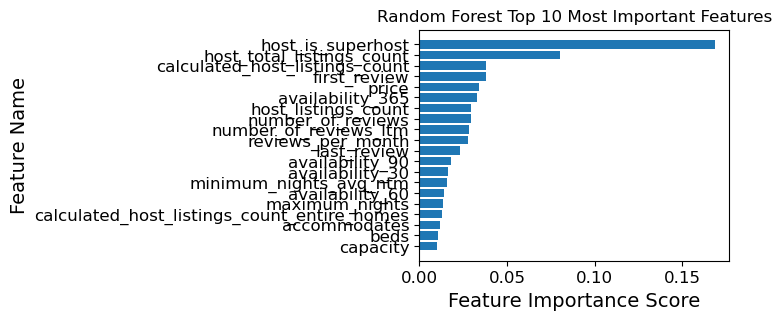

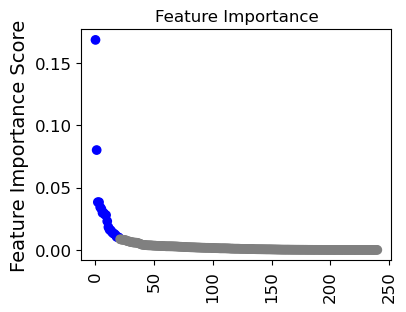

In [20]:
insights_with_sentiment = pd.read_csv('bdd_barcelona/processed/Test-5/filtered_insights_25_senti_GPT.csv')

filtered_insights = filter_accomodation_num_review(insights_with_sentiment, 'number_of_reviews', min_reviews)
col_names = ['sent1','sent2','sent3','sent4','sent5','sent6','sent7','sent8','sent9','sent10','sentiment']
columns_to_drop = [col for col in col_names if col in filtered_insights.columns]
filtered_insights.drop(columns=columns_to_drop, inplace=True)

min_reviews = 50
sentiment = True
recalculate = False

# Train/load model
model,A,B,results_df = mod_maker.load_rf_model(filtered_insights,"Sentiment_GPT_50",recalculate)
display(model)

# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

#mod_maker.plot_all_results(y_test,y_pred_rf)
mod_maker.feature_importance(X_train,model)

## Location analisys

### Initial analysis

In [6]:
import shap
from sklearn.model_selection  import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

insights_with_sentiment = pd.read_csv('bdd_barcelona/processed/Test-5/filtered_insights_25_senti_GPT.csv')

min_reviews = 50

filtered_insights = filter_accomodation_num_review(insights_with_sentiment, 'number_of_reviews', min_reviews)
col_names = ['sent1','sent2','sent3','sent4','sent5','sent6','sent7','sent8','sent9','sent10']
columns_to_drop = [col for col in col_names if col in filtered_insights.columns]
filtered_insights.drop(columns=columns_to_drop, inplace=True)
#insights = pd.read_csv(f'bdd_barcelona/GPT/filtered_insights_25_senti_GPT.csv')
#print(list(insights.columns))

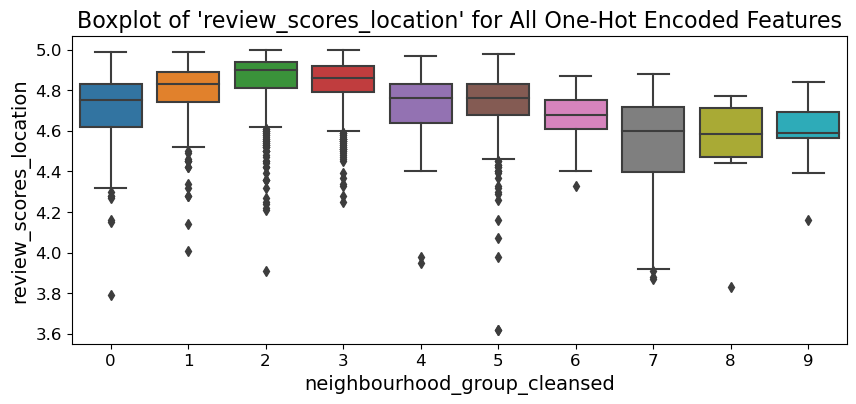

+------------+---------------------+
| Attributes |       Values        |
+------------+---------------------+
|     0      |     Sant Martí      |
|     1      |       Gràcia        |
|     2      |    Ciutat Vella     |
|     3      |      Eixample       |
|     4      | Sarrià-Sant Gervasi |
|     5      |   Sants-Montjuïc    |
|     6      |      Les Corts      |
|     7      |   Horta-Guinardó    |
|     8      |     Nou Barris      |
|     9      |     Sant Andreu     |
+------------+---------------------+

In [7]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='neighbourhood_group_cleansed', y='review_scores_location', data=filtered_insights)
plt.title("Boxplot of 'review_scores_location' for All One-Hot Encoded Features", fontsize=16)

legend_labels = filtered_insights['neighbourhood_group_cleansed'].unique()
plt.xticks(range(10), [str(i) for i in range(10)])
plt.show()

from tabulate import tabulate

# Create a DataFrame for the table
table_data = {'Attributes': range(10), 'Values': [legend_labels[i] for i in range(10)]}
df_table = pd.DataFrame(table_data)

# Print the DataFrame as a nice table
table = tabulate(df_table, headers='keys', tablefmt='pretty', showindex=False)
print(table)

In [8]:
feature_stats_df = filtered_insights.groupby('neighbourhood_group_cleansed')['review_scores_location'].describe()
display(feature_stats_df)
feature_stats_df = filtered_insights.groupby('neighbourhood_cleansed')['review_scores_location'].describe()
feature_stats_df = feature_stats_df[feature_stats_df['count'] >= 4]

pd.set_option('display.max_rows', None)
display(feature_stats_df.head(64))
pd.reset_option('display.max_rows')

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Ciutat Vella,623.0,4.852343,0.140970,3.91,4.8100,4.900,4.9400,5.00
Eixample,1767.0,4.846423,0.103740,4.25,4.7900,4.860,4.9200,5.00
Gràcia,415.0,4.800434,0.133467,4.01,4.7400,4.830,4.8900,4.99
Horta-Guinardó,108.0,4.529444,0.252993,3.87,4.3975,4.600,4.7200,4.88
Les Corts,73.0,4.663562,0.116683,4.33,4.6100,4.680,4.7500,4.87
Nou Barris,22.0,4.559545,0.200653,3.83,4.4700,4.585,4.7125,4.77
Sant Andreu,18.0,4.603333,0.152122,4.16,4.5625,4.590,4.6950,4.84
Sant Martí,364.0,4.713434,0.159372,3.79,4.6200,4.750,4.8300,4.99
Sants-Montjuïc,460.0,4.730848,0.155532,3.62,4.6800,4.760,4.8300,4.98


,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Can Baró,14.0,4.512143,0.191238,4.21,4.3400,4.550,4.6500,4.84
Diagonal Mar i el Front Marítim del Poblenou,38.0,4.714474,0.123785,4.39,4.6325,4.735,4.8075,4.91
Hostafrancs,45.0,4.802000,0.080442,4.67,4.7500,4.800,4.8400,4.98
Navas,5.0,4.606000,0.145705,4.39,4.5700,4.590,4.7200,4.76
Pedralbes,8.0,4.651250,0.211149,4.33,4.4675,4.750,4.8050,4.87
Provençals del Poblenou,16.0,4.632500,0.252283,3.79,4.5975,4.670,4.7700,4.88
Sant Andreu,4.0,4.620000,0.087560,4.56,4.5750,4.585,4.6300,4.75
Sant Antoni,253.0,4.810277,0.096137,4.47,4.7600,4.820,4.8800,5.00
Sant Gervasi - Galvany,60.0,4.780000,0.122433,4.48,4.7000,4.800,4.8900,4.97


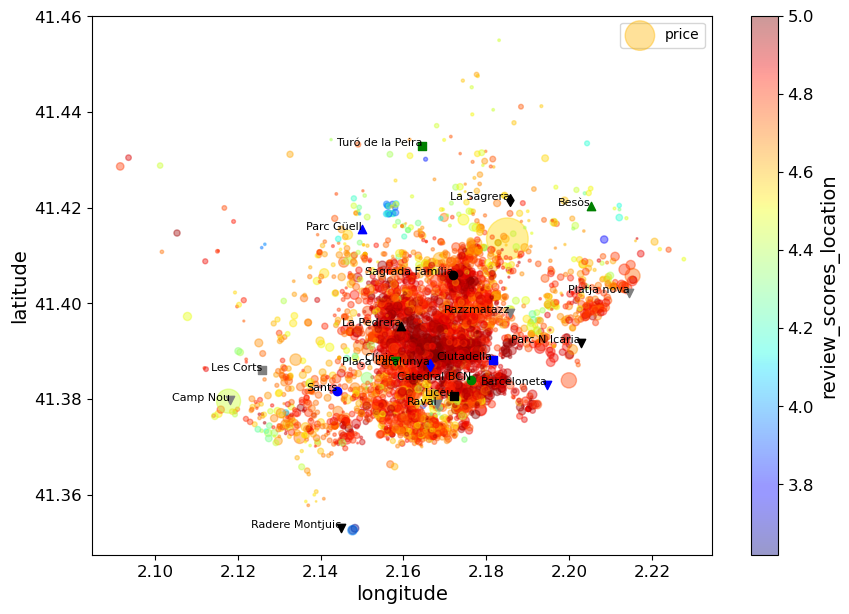

In [9]:
try:
    filtered_insights["price"] = filtered_insights["price"].apply(lambda x: float(x.replace("$", "").replace(",", "")))
except (AttributeError, ValueError) as e:
    print("Price already transformed to float")


filtered_insights.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
              s=filtered_insights['price']/10, label='price', figsize=(10,7),
              c="review_scores_location", cmap=plt.get_cmap("jet"), colorbar=True,
              sharex=False)

# Add scatter points for landmarks with different markers and colors
plt.scatter(2.1720037, 41.4060085, c='black', marker='o', label='Sagrada Família')
plt.scatter(2.1593474, 41.3952872, c='black', marker='^', label='La Pedrera')
plt.scatter(2.1723068, 41.380741, c='black', marker='s', label='Liceu')
plt.scatter(2.1857127, 41.421634, c='black', marker='d', label='La Sagrera')
plt.scatter(2.1448975, 41.3531466, c='black', marker='v', label='Radere Montjuic')
plt.scatter(2.1662986, 41.3871498, c='blue', marker='d', label='Plaça catalunya')
plt.scatter(2.1815693, 41.388152, c='blue', marker='s', label='Ciutadella')
plt.scatter(2.1439974, 41.3817246, c='blue', marker='o', label='Sants')
plt.scatter(2.1499003, 41.4155128, c='blue', marker='^', label='Parc Güell')
plt.scatter(2.1947006, 41.382989, c='blue', marker='v', label='Barceloneta')
plt.scatter(2.1580019, 41.3880077, c='green', marker='v', label='Clínic')
plt.scatter(2.1763053, 41.384097, c='green', marker='o', label='Catedral BCN')
plt.scatter(2.205259, 41.4203897, c='green', marker='^', label='Besòs')
plt.scatter(2.1645503, 41.4329238, c='green', marker='s', label='Turó de la Peira')
plt.scatter(2.1258811, 41.3860349, c='grey', marker='s', label='Les Corts')
plt.scatter(2.1857993, 41.3979823, c='grey', marker='v', label='Razzmatazz')
plt.scatter(2.214512,41.402274, c='grey', marker='v', label='Platja nova')
plt.scatter(2.1180945,41.3797289, c='grey', marker='v', label='Camp Nou')
plt.scatter(2.1681625,41.3789204, c='grey', marker='v', label='Raval')
plt.scatter(2.2028073,41.3917361, c='black', marker='v', label='Parc N Icaria')



# Fill in the landmark dictionary with locations and coordinates
landmark_dict = {
    'Sagrada Família': (2.1720037, 41.4060085),
    'La Pedrera': (2.1593474, 41.3952872),
    'Liceu': (2.1723068, 41.380741),
    'La Sagrera': (2.1857127, 41.421634),
    'Radere Montjuic': (2.1448975, 41.3531466),
    'Plaça catalunya': (2.1662986, 41.3871498),
    'Ciutadella': (2.1815693, 41.388152),
    'Sants': (2.1439974, 41.3817246),
    'Parc Güell': (2.1499003, 41.4155128),
    'Barceloneta': (2.1947006, 41.382989),
    'Clínic': (2.1580019, 41.3880077),
    'Catedral BCN': (2.1763053, 41.384097),
    'Besòs': (2.205259, 41.4203897),
    'Turó de la Peira': (2.1645503, 41.4329238),
    'Les Corts': (2.1258811, 41.3860349),
    'Razzmatazz': (2.1857993, 41.3979823),
    'Platja nova': (2.214512,41.402274),
    'Camp Nou': (2.1180945,41.3797289),
    'Raval': (2.1681625,41.3789204),
    'Parc N Icaria': (2.2028073,41.3917361)
}

# Add labels for landmarks
for landmark, (lon, lat) in landmark_dict.items():
    plt.text(lon, lat, landmark, fontsize=8, ha='right')

#plt.legend()
#plt.savefig("images/location_map.png")
plt.show()


### Create new features

In [10]:
def euclidean_distance(lon1, lat1, lon2, lat2):
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

euc_features = []
for landmark, (lon, lat) in landmark_dict.items():
    column_name = f'Eucld_{landmark}'
    filtered_insights[column_name] = euclidean_distance(filtered_insights['longitude'], filtered_insights['latitude'], lon, lat)
    euc_features.append(column_name)
#print(insights.head())
print(euc_features)
filtered_insights.to_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv",index=False)


[
    'Eucld_Sagrada Família',
    'Eucld_La Pedrera',
    'Eucld_Liceu',
    'Eucld_La Sagrera',
    'Eucld_Radere Montjuic',
    'Eucld_Plaça catalunya',
    'Eucld_Ciutadella',
    'Eucld_Sants',
    'Eucld_Parc Güell',
    'Eucld_Barceloneta',
    'Eucld_Clínic',
    'Eucld_Catedral BCN',
    'Eucld_Besòs',
    'Eucld_Turó de la Peira',
    'Eucld_Les Corts',
    'Eucld_Razzmatazz',
    'Eucld_Platja nova',
    'Eucld_Camp Nou',
    'Eucld_Raval',
    'Eucld_Parc N Icaria'
]

### Predicting Location score

In [9]:
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")


eucl_list = ['Eucld_Sagrada Família', 'Eucld_La Pedrera', 'Eucld_Liceu', 'Eucld_La Sagrera', 'Eucld_Radere Montjuic', 'Eucld_Plaça catalunya',
                        'Eucld_Ciutadella', 'Eucld_Sants', 'Eucld_Parc Güell', 'Eucld_Barceloneta', 'Eucld_Clínic','Eucld_Catedral BCN',
                        'Eucld_Besòs', 'Eucld_Turó de la Peira', 'Eucld_Les Corts', 'Eucld_Razzmatazz', 'Eucld_Platja nova', 'Eucld_Camp Nou',
                        'Eucld_Raval', 'Eucld_Parc N Icaria']
outpus_types = ['review_scores_rating', 'review_scores_accuracy',
            'review_scores_cleanliness', 'review_scores_checkin',
            'review_scores_communication', 'review_scores_location',
            'review_scores_value']
host_list = ['average_value_per_listing_id','host_listings_count','bathrooms_text']
one_hot_list = ['neighbourhood_group_cleansed','neighbourhood_cleansed',"property_type","room_type"]
idd = ['id']

--------------------------Model Not Found----------------------------

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------+-----------------------------+--------+--------+
|         Model         |          Score type         |  R^2   |  MSE   |
+-----------------------+-----------------------------+--------+--------+
| RF >Location_fullrevi |     review_scores_rating    | 0.5238 | 0.0219 |
| RF >Location_fullrevi |    review_scores_accuracy   | 0.4560 | 0.0176 |
| RF >Location_fullrevi |  review_scores_cleanliness  | 0.3660 | 0.0301 |
| RF >Location_fullrevi |    review_scores_checkin    | 0.6395 | 0.0128 |
| RF >Location_fullrevi | review_scores_communication | 0.5525 | 0.0126 |
| RF >Location_fullrevi |    review_scores_location   | 0.5757 | 0.0107 |
| RF >Location_fullrevi |     review_scores_value     | 0.5205 | 0.0192 |
+-----------------------+-----------------------------+--------+--------+

3.6340797826723996

-----------------------------Model Loaded----------------------------

RandomForestRegressor(random_state=0)

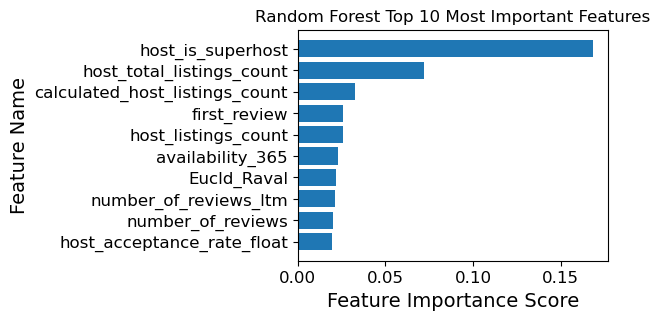

review_scores_rating

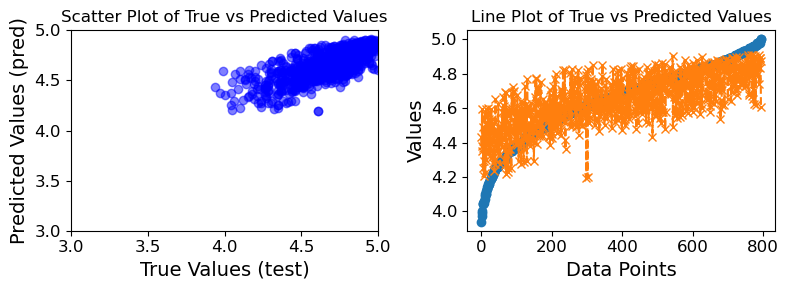

review_scores_accuracy

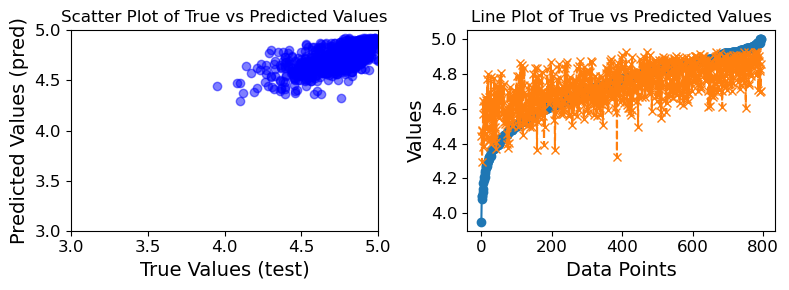

review_scores_cleanliness

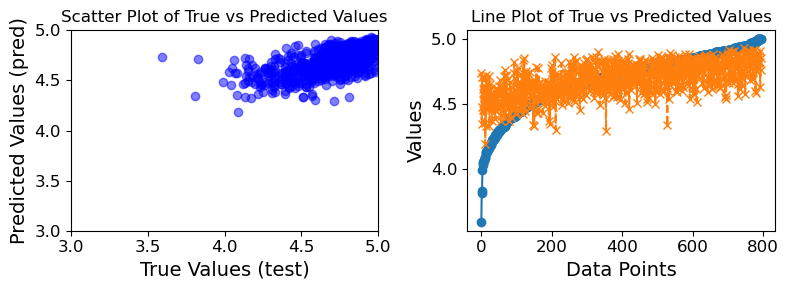

review_scores_checkin

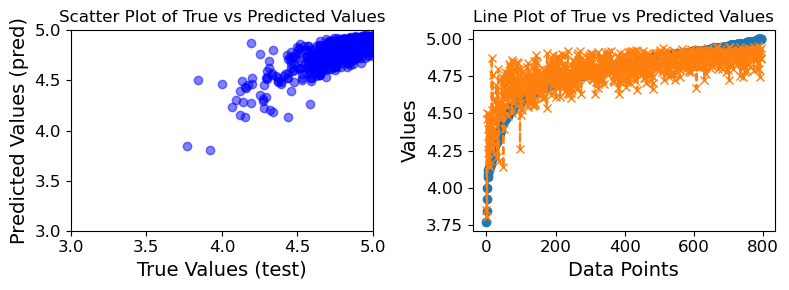

review_scores_communication

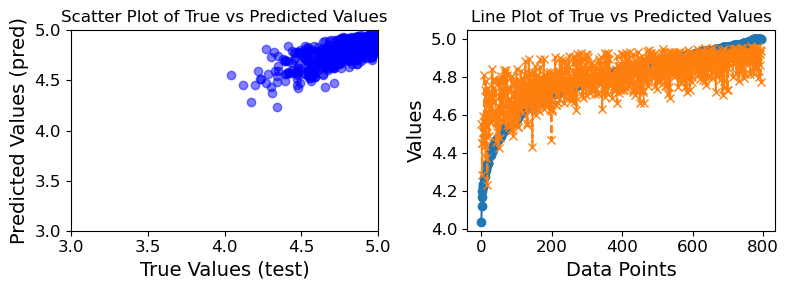

review_scores_location

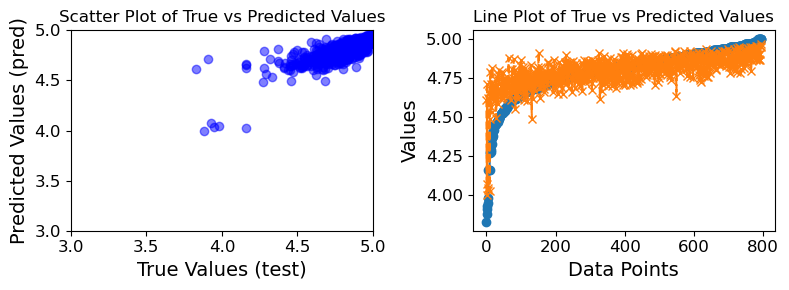

review_scores_value

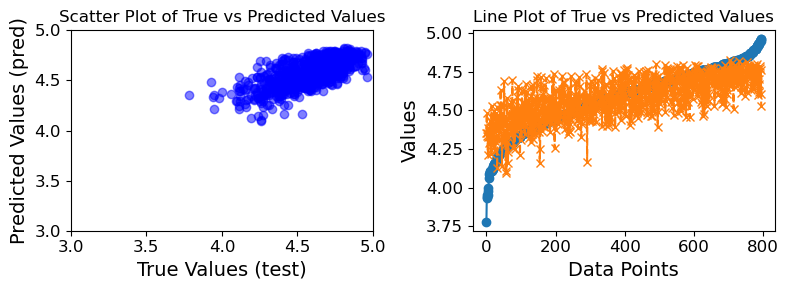

In [10]:
sentiment = True
recalculate = True

# Create a filtered database 

insights_location = filtered_insights[eucl_list + host_list + one_hot_list + idd + ['review_scores_location']]

# Train/load model
model,A,B,results_df = mod_maker.load_rf_model(filtered_insights,"Location_full",recalculate)
display(model)


# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

#mod_maker.plot_all_results(y_test,y_pred_rf)
mod_maker.feature_importance(X_train,model,False)
mod_maker.plot_all_results(y_test,y_pred_rf,False)

--------------------------Model Not Found----------------------------

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 28)

Shape of A after full transforming: (3974, 140)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------+------------------------+--------+--------+
|         Model         |       Score type       |  R^2   |  MSE   |
+-----------------------+------------------------+--------+--------+
| RF >Location_testrevi | review_scores_location | 0.6175 | 0.0097 |
+-----------------------+------------------------+--------+--------+

0.617509490914929

-----------------------------Model Loaded----------------------------

RandomForestRegressor(random_state=0)

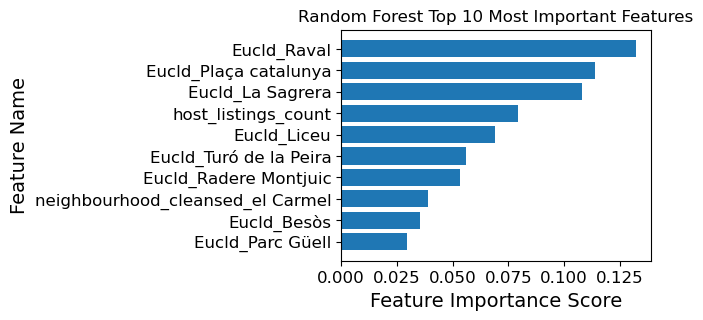

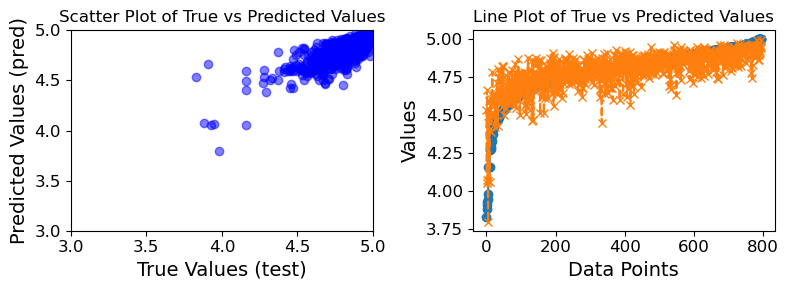

In [6]:
sentiment = True
recalculate = False

# Create a filtered database 

insights_location = filtered_insights[eucl_list + host_list + one_hot_list + idd + ['review_scores_location']]

# Train/load model
model,A,B,results_df = mod_maker.load_rf_model(insights_location,"Location_test",recalculate)
display(model)


# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

#mod_maker.plot_all_results(y_test,y_pred_rf)
mod_maker.feature_importance(X_train,model,False)
mod_maker.visualise_outcom(y_test.values.flatten(),y_pred_rf,False)

In [15]:
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
def train_several_models(results_df):
    for i in [None,['average_value_per_listing_id','host_listings_count'],'average_value_per_listing_id','host_listings_count']:
        if isinstance(i,list):
            insights_location = filtered_insights[eucl_list + one_hot_list + idd + ['review_scores_location'] + i]
        elif i is None:
            insights_location = filtered_insights[eucl_list + one_hot_list + idd + ['review_scores_location']]
        else:
            insights_location = filtered_insights[eucl_list + one_hot_list + idd + ['review_scores_location'] + [i]]
        A,B = data_processer.bdd_premodel(insights_location,recalculate = True)
        results_df = mod_maker.model_testing(A,B,i,results_df) 
    return results_df

results_df = find_optimal_min_review(results_df)
display(results_df)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 25)

Shape of A after full transforming: (3974, 138)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+--------------+------------------------+--------+--------+
|    Model     |       Score type       |  R^2   |  MSE   |
+--------------+------------------------+--------+--------+
| RF >Nonerevi | review_scores_location | 0.5569 | 0.0112 |
+--------------+------------------------+--------+--------+

0.5569330947463669

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 27)

Shape of A after full transforming: (3974, 139)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------------------------------------------------+------------------------+--------+--------+
|                              Model                              |       Score type       |  R^2   |  MSE   |
+-----------------------------------------------------------------+------------------------+--------+--------+
| RF >['average_value_per_listing_id', 'host_listings_count']revi | review_scores_location | 0.6169 | 0.0097 |
+-----------------------------------------------------------------+------------------------+--------+--------+

0.6169006663752734

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 26)

Shape of A after full transforming: (3974, 138)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+--------------------------------------+------------------------+--------+--------+
|                Model                 |       Score type       |  R^2   |  MSE   |
+--------------------------------------+------------------------+--------+--------+
| RF >average_value_per_listing_idrevi | review_scores_location | 0.5569 | 0.0112 |
+--------------------------------------+------------------------+--------+--------+

0.5569330947463669

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 26)

Shape of A after full transforming: (3974, 139)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------------+------------------------+--------+--------+
|            Model            |       Score type       |  R^2   |  MSE   |
+-----------------------------+------------------------+--------+--------+
| RF >host_listings_countrevi | review_scores_location | 0.6169 | 0.0097 |
+-----------------------------+------------------------+--------+--------+

0.6169006663752734

,Model,Score type,R^2,MSE
0,RF >Nonerevi,review_scores_location,0.556933,0.011212
1,"RF >['average_value_per_listing_id', 'host_listings_count']revi",review_scores_location,0.616901,0.009694
2,RF >average_value_per_listing_idrevi,review_scores_location,0.556933,0.011212
3,RF >host_listings_countrevi,review_scores_location,0.616901,0.009694


In [11]:
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")
def train_several_models(results_df):
    for i in outpus_types:
        insights_location = filtered_insights.copy()
        cols_to_drop = [item for item in outpus_types if item != i]
        insights_location.drop(columns=cols_to_drop, inplace=True)
        
        A,B = data_processer.bdd_premodel(insights_location,recalculate = True)
        results_df = mod_maker.model_testing(A,B,i,results_df) 
        
    insights_location = filtered_insights.copy()
    A,B = data_processer.bdd_premodel(insights_location,recalculate = True)
    results_df = mod_maker.model_testing(A,B,'location_full',results_df) 
    return results_df
results_df = train_several_models(results_df)
display(results_df)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------------------------+----------------------+--------+--------+
|            Model             |      Score type      |  R^2   |  MSE   |
+------------------------------+----------------------+--------+--------+
| RF >review_scores_ratingrevi | review_scores_rating | 0.5350 | 0.0214 |
+------------------------------+----------------------+--------+--------+

0.534983234667543

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+--------------------------------+------------------------+--------+--------+
|             Model              |       Score type       |  R^2   |  MSE   |
+--------------------------------+------------------------+--------+--------+
| RF >review_scores_accuracyrevi | review_scores_accuracy | 0.4446 | 0.0179 |
+--------------------------------+------------------------+--------+--------+

0.4445728908704242

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------------------+---------------------------+--------+--------+
|               Model               |         Score type        |  R^2   |  MSE   |
+-----------------------------------+---------------------------+--------+--------+
| RF >review_scores_cleanlinessrevi | review_scores_cleanliness | 0.3597 | 0.0304 |
+-----------------------------------+---------------------------+--------+--------+

0.3596601706178656

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------------------------+-----------------------+--------+--------+
|             Model             |       Score type      |  R^2   |  MSE   |
+-------------------------------+-----------------------+--------+--------+
| RF >review_scores_checkinrevi | review_scores_checkin | 0.6582 | 0.0122 |
+-------------------------------+-----------------------+--------+--------+

0.6581953590249652

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------------------------------+-----------------------------+--------+--------+
|                Model                |          Score type         |  R^2   |  MSE   |
+-------------------------------------+-----------------------------+--------+--------+
| RF >review_scores_communicationrevi | review_scores_communication | 0.5719 | 0.0121 |
+-------------------------------------+-----------------------------+--------+--------+

0.5719217615254875

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+--------------------------------+------------------------+--------+--------+
|             Model              |       Score type       |  R^2   |  MSE   |
+--------------------------------+------------------------+--------+--------+
| RF >review_scores_locationrevi | review_scores_location | 0.6489 | 0.0089 |
+--------------------------------+------------------------+--------+--------+

0.6489023083002372

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------------+---------------------+--------+--------+
|            Model            |      Score type     |  R^2   |  MSE   |
+-----------------------------+---------------------+--------+--------+
| RF >review_scores_valuerevi | review_scores_value | 0.5227 | 0.0191 |
+-----------------------------+---------------------+--------+--------+

0.5227270975907374

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------+-----------------------------+--------+--------+
|         Model         |          Score type         |  R^2   |  MSE   |
+-----------------------+-----------------------------+--------+--------+
| RF >location_fullrevi |     review_scores_rating    | 0.5238 | 0.0219 |
| RF >location_fullrevi |    review_scores_accuracy   | 0.4560 | 0.0176 |
| RF >location_fullrevi |  review_scores_cleanliness  | 0.3660 | 0.0301 |
| RF >location_fullrevi |    review_scores_checkin    | 0.6395 | 0.0128 |
| RF >location_fullrevi | review_scores_communication | 0.5525 | 0.0126 |
| RF >location_fullrevi |    review_scores_location   | 0.5757 | 0.0107 |
| RF >location_fullrevi |     review_scores_value     | 0.5205 | 0.0192 |
+-----------------------+-----------------------------+--------+--------+

3.6340797826723996

,Model,Score type,R^2,MSE
0,RF >review_scores_ratingrevi,review_scores_rating,0.534983,0.021363
1,RF >review_scores_accuracyrevi,review_scores_accuracy,0.444573,0.017927
2,RF >review_scores_cleanlinessrevi,review_scores_cleanliness,0.359660,0.030436
3,RF >review_scores_checkinrevi,review_scores_checkin,0.658195,0.012178
4,RF >review_scores_communicationrevi,review_scores_communication,0.571922,0.012088
5,RF >review_scores_locationrevi,review_scores_location,0.648902,0.008885
6,RF >review_scores_valuerevi,review_scores_value,0.522727,0.019110
7,RF >location_fullrevi,review_scores_rating,0.523823,0.021876
8,RF >location_fullrevi,review_scores_accuracy,0.455990,0.017558
9,RF >location_fullrevi,review_scores_cleanliness,0.366046,0.030133


--------------------------Model Not Found----------------------------

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (3974, 93)

Price already transformed to float

Shape of A after full transforming: (3974, 333)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------------------+------------------------+--------+--------+
|         Model         |       Score type       |  R^2   |  MSE   |
+-----------------------+------------------------+--------+--------+
| RF >Location_bestrevi | review_scores_location | 0.6489 | 0.0089 |
+-----------------------+------------------------+--------+--------+

0.6489023083002372

-----------------------------Model Loaded----------------------------

RandomForestRegressor(random_state=0)

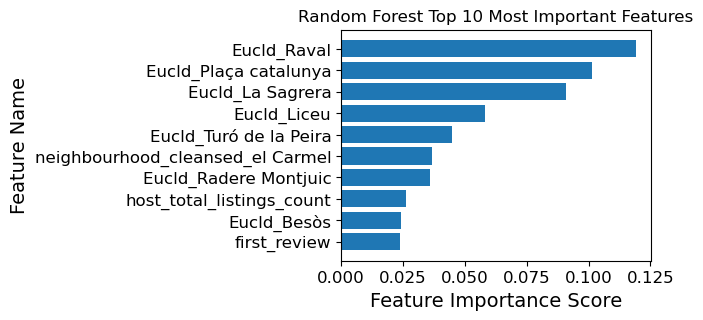

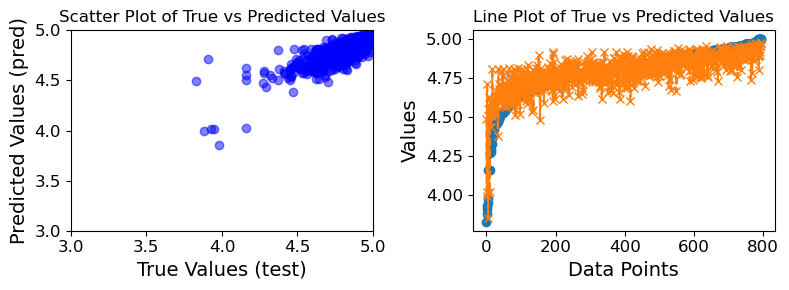

In [6]:
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")
sentiment = True
recalculate = False

# Create a filtered database 

insights_location = filtered_insights
cols_to_drop = [item for item in outpus_types if item != 'review_scores_location']
insights_location.drop(columns=cols_to_drop, inplace=True)


# Train/load model
model,A,B,results_df = mod_maker.load_rf_model(insights_location,"Location_best",recalculate)
display(model)


# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

#mod_maker.plot_all_results(y_test,y_pred_rf)
mod_maker.feature_importance(X_train,model,False)
mod_maker.visualise_outcom(y_test.values.flatten(),y_pred_rf,False)

## Missing values

In [17]:
# Lets look into the missing values in the score variables
outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
results = {}
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")

In [18]:
results = {}
total = len(filtered_insights.index)
for i in outpus_types:
    results[i] = filtered_insights[i].isnull().sum()/total

    
missing_values_per_row = filtered_insights.isnull().sum(axis=1)
rows_with_more_than_4_missing_values = filtered_insights[missing_values_per_row > 5]
print("-------------------------Missing values in rows------------------------------------")
print(f"The percentage of accomodations with at least 5 missing values is: {len(rows_with_more_than_4_missing_values)/len(filtered_insights)}, therefore I cannot just delete all rows with at least 5 missings. We will treat each atribute differently")

print("-------------------------Percentage of missing values per review score------------------------------------")
display(results)
results = {}
print("As we can see from the previouse dictionary, there are no missing values on any of the review scores for the accomodations that have over 25 reviews/accomodation. This is very good.")
for i in list(filtered_insights.columns):
    value = filtered_insights[i].isnull().sum()/total * 100
    if value != 0:
        results[i] = value.__round__(2)

sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

print("-------------------------Percentage of missing values per feature------------------------------------")
print("We are only going to be printing the ones with non 0 amound")
display(sorted_results)
print("""We don't have a lot of missing data, yet it is not uniform across all columns and rows. This means that we need to use different approaches for every scenario, we can extract a few things from this experiment:
      - 'calendar_updated' can be deleted since they dont have any meaningfull value.
      - 'bathrooms' will be filled with the data from bathroom_text wich contains all the information neaded
      - The ones that have upwards of 20% of missing values, could be repaced with a boolean variable saying missing or not.
        - Afer further investigation, all ot these missing values are evenly distributed when looking at all of the score metrics.
      - The ones that are below 1% can be just set to the mean or delete the hole row, I will chose the mean method.
      - For the ones that are close to 10% I will just set to the mean.
""")

-------------------------Missing values in rows------------------------------------

The percentage of accomodations with at least 5 missing values is: 0.18847508807247107, therefore I cannot just 
delete all rows with at least 5 missings. We will treat each atribute differently

-------------------------Percentage of missing values per review score------------------------------------

{'review_scores_rating': 0.0,
 'review_scores_accuracy': 0.0,
 'review_scores_cleanliness': 0.0,
 'review_scores_checkin': 0.0,
 'review_scores_communication': 0.0,
 'review_scores_location': 0.0,
 'review_scores_value': 0.0}

As we can see from the previouse dictionary, there are no missing values on any of the review scores for the 
accomodations that have over 25 reviews/accomodation. This is very good.

-------------------------Percentage of missing values per feature------------------------------------

We are only going to be printing the ones with non 0 amound

{'bathrooms': 100.0,
 'calendar_updated': 100.0,
 'neighborhood_overview': 25.44,
 'neighbourhood': 25.44,
 'host_neighbourhood': 23.13,
 'bedrooms': 22.07,
 'license': 19.98,
 'host_about': 19.95,
 'host_is_superhost': 19.78,
 'host_location': 11.83,
 'host_response_time': 8.03,
 'host_response_rate': 8.03,
 'host_acceptance_rate': 6.24,
 'beds': 0.63,
 'bathrooms_text': 0.1,
 'description': 0.03}

We don't have a lot of missing data, yet it is not uniform across all columns and rows. This means that we need to 
use different approaches for every scenario, we can extract a few things from this experiment:
      - 'calendar_updated' can be deleted since they dont have any meaningfull value.
      - 'bathrooms' will be filled with the data from bathroom_text wich contains all the information neaded
      - The ones that have upwards of 20% of missing values, could be repaced with a boolean variable saying 
missing or not.
        - Afer further investigation, all ot these missing values are evenly distributed when looking at all of the
score metrics.
      - The ones that are below 1% can be just set to the average or delete the hole row, I will chose the average 
method.
      - For the ones that are close to 10% I will just set to the average.

In [12]:
# 6-----------------------------------FORMAT bathrooms_text--------------------------------------------------

filtered_insights["bathrooms"] = filtered_insights["bathrooms_text"].str.extract(r'(\d+(\.\d+)?)', expand=False)[0].astype(float)
print(filtered_insights["bathrooms"])
per = filtered_insights["bathrooms"].isnull().sum()/5678
print(f"In this process, we have only generated {per} new missing values wich is acceptable.")

0       2.0
1       1.5
2       2.0
3       3.0
4       1.0
       ... 
3969    1.5
3970    1.0
3971    1.0
3972    1.5
3973    1.0
Name: bathrooms, Length: 3974, dtype: float64

In this process, we have only generated 0.0017611835153222965 new missing values wich is acceptable.

In [27]:
# Remove '%' and convert to float
filtered_insights["host_acceptance_rate_float"] = filtered_insights["host_acceptance_rate"].str.rstrip('%').astype('float') / 100.0
filtered_insights["host_response_rate_float"] = filtered_insights["host_response_rate"].str.rstrip('%').astype('float') / 100.0

# Print the DataFrame with the new column
print(filtered_insights["host_acceptance_rate_float"])


0       1.00
1       1.00
2       0.83
3       0.97
4       1.00
        ... 
3969    1.00
3970    1.00
3971    1.00
3972    0.94
3973    1.00
Name: host_acceptance_rate_float, Length: 3974, dtype: float64

In [29]:
filtered_insights["host_response_rate"]

0       100%
1       100%
2        97%
3        91%
4       100%
        ... 
3969    100%
3970    100%
3971    100%
3972    100%
3973     99%
Name: host_response_rate, Length: 3974, dtype: object

## Outliers

In [13]:
outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
results = {}
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")

In [52]:
print("""We will study the 5 accomodations with higher and lower reviwe scores in the 7 different categories and try to extract some patterns or some valuable information to improve our chance to find patterns""")

outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
results = {}
total = pd.DataFrame()
bad = pd.DataFrame()
good = pd.DataFrame()
for column in outpus_types:
    top_5_high = filtered_insights.nlargest(5, column)
    top_5_low = filtered_insights.nsmallest(5, column)
    print(f"Top 5 rows with highest values in '{column}':")
    print(top_5_high)
    print("\n")
    print(f"Top 5 rows with lowest values in '{column}':")
    print(top_5_low)

    results[column] = {"H":top_5_high,"L":top_5_low}
    total = pd.concat([top_5_high,top_5_low,total],axis=0)
    good = pd.concat([top_5_high,good],axis=0)
    bad = pd.concat([top_5_low,bad],axis=0)

print(len(total['id'].unique()))

#display(results['review_scores_rating']["L"])


We will study the 5 accomodations with higher and lower reviwe scores in the 7 different categories and try to 
extract some patterns or some valuable information to improve our chance to find patterns

Top 5 rows with highest values in 'review_scores_rating':

id                            listing_url     scrape_id  \
1067   4486999.0   https://www.airbnb.com/rooms/4486999  2.023060e+13   
1323   6970615.0   https://www.airbnb.com/rooms/6970615  2.023060e+13   
1718  13347472.0  https://www.airbnb.com/rooms/13347472  2.023060e+13   
1875  15668556.0  https://www.airbnb.com/rooms/15668556  2.023060e+13   
2793  27226488.0  https://www.airbnb.com/rooms/27226488  2.023060e+13   

     last_scraped           source  \
1067    6/10/2023      city scrape   
1323    6/10/2023      city scrape   
1718    6/10/2023      city scrape   
1875    6/10/2023  previous scrape   
2793    6/10/2023  previous scrape   

                                                                        name  \
1067  Serviced apartment in Barcelona · ★5.0 · 2 bedrooms · 2 beds · 2 baths   
1323               Condo in Barcelona · ★5.0 · 4 bedrooms · 7 beds · 3 baths   
1718         Rental unit in Barcelona · ★5.0 · 2 bedrooms · 3 beds · 2 baths   
1875          Rental unit in Barcelona · ★5.0 · 2 bedrooms · 3 beds · 1 bath   
2793  Rental unit in Barcelona · ★5.0 · 1 bedroom · 1 bed · 1.5 shared baths   

                                                                                              description  \
1067  Playful 2 bedroom 2 bathroom penthouse with a private terrace<br /><br /><b>The space</b><br />P...   
1323  A stunning 223 sqm Catalan penthouse in the heart of Passeig de Gracia, in the center of Barcelo...   
1718  This unique luxury penthouse with huge and sunny private terrace is located right in the centre ...   
1875  Luminoso apartamento con impresionantes vistas de la Sagrada Familia.<br />Recien reformado, per...   
2793  Welcome to my apartment. Located in the heart of Barcelona in the Eixample district. Not only is...   

                                                                                    neighborhood_overview  \
1067  The Tengujo penthouse apartment is situated just by the popular and vibrant areas of Eixample, G...   
1323  Located in a residential building built by Buenaventura Conill i Montobbio (one of Antonio Gaudi...   
1718  The penthouse is located right in the centre of the city next to Plaza Catalunya and La Rambla. ...   
1875                                                                                                  NaN   
2793                                                                                                  NaN   

                                                                    picture_url  \
1067            https://a0.muscache.com/pictures/56347687/f717da34_original.jpg   
1323            https://a0.muscache.com/pictures/97651757/a809355c_original.jpg   
1718  https://a0.muscache.com/pictures/93b2e37b-9e4f-43f1-bab7-97aa11c8ce45.jpg   
1875  https://a0.muscache.com/pictures/82f1f03d-453a-4740-b13e-c87580eb6e4d.jpg   
2793  https://a0.muscache.com/pictures/9326f6d3-618e-40a7-a4a0-15c6208ea338.jpg   

        host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
1067    3590196  ...     0.007403           0.011318    0.052614   
1323   36548701  ...     0.007736           0.013347    0.049680   
1718   75642860  ...     0.010048           0.008670    0.051000   
1875  101182990  ...     0.023073           0.019557    0.034600   
2793   35327702  ...     0.011949           0.012093    0.045461   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
1067               0.046648        0.039320         0.023691   
1323               0.041687        0.039493         0.021836   
1718               0.047256        0.041920         0.021746   
1875               0.031121        0.052168         0.012178   
2793               0.039685        0.043397         0.017748   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
1067          0.051841       0.047559    0.007933            0.038001  
1323          0.050697       0.048326    0.012712            0.037781  
1718          0.049538       0.050072    0.006

Top 5 rows with lowest values in 'review_scores_rating':

id                            listing_url     scrape_id  \
3352  40907800.0  https://www.airbnb.com/rooms/40907800  2.023060e+13   
3669  49917346.0  https://www.airbnb.com/rooms/49917346  2.023060e+13   
3679  50064223.0  https://www.airbnb.com/rooms/50064223  2.023060e+13   
3596  46405629.0  https://www.airbnb.com/rooms/46405629  2.023060e+13   
3856  53537950.0  https://www.airbnb.com/rooms/53537950  2.023060e+13   

     last_scraped       source  \
3352    6/10/2023  city scrape   
3669    6/10/2023  city scrape   
3679    6/10/2023  city scrape   
3596    6/10/2023  city scrape   
3856    6/10/2023  city scrape   

                                                                    name  \
3352            Loft in Barcelona · ★3.66 · 2 bedrooms · 4 beds · 1 bath   
3669  Rental unit in Barcelona · ★3.76 · 4 bedrooms · 5 beds · 1.5 baths   
3679            Hotel in Barcelona · ★3.84 · 1 bedroom · 3 beds · 1 bath   
3596    Rental unit in Barcelona · ★3.87 · 3 bedrooms · 5 beds · 2 baths   
3856     Hotel in Barcelona · ★3.90 · 1 bedroom · 1 bed · 1 private bath   

                                                                                              description  \
3352  Precioso apartamento de techos altos con 2 dormitorios situado a 15 minutos caminando del centro...   
3669  El apartamento está totalmente equipado con todo lo necesario para una estancia agradable, dispo...   
3679  Beautiful suite-type room, with private bathroom, 18-20 square meters, with a double bed and an ...   
3596  A beautiful flat in the royal champrey of Barcelona which is very peaceful, sunny and luminous.<...   
3856  Our cosy Classic Double Room ensure you a good night’s sleep, whether alone or with company.<br ...   

                                                                                    neighborhood_overview  \
3352  El apartamento está situado en una calle tranquila donde podrá descansar cómodamente aunque enco...   
3669                                                                                                  NaN   
3679  It is an accommodation with a privileged location. 5 minutes from Calle Diagonal and Paseo de Gr...   
3596                                                                                                  NaN   
3856                                                                                                  NaN   

                                                                                              picture_url  \
3352                            https://a0.muscache.com/pictures/db69f2bb-ea58-4dc2-8e51-0ac751cad3b5.jpg   
3669  https://a0.muscache.com/pictures/prohost-api/Hosting-34457900/original/5ce81935-d755-4a27-83bf-6...   
3679  https://a0.muscache.com/pictures/prohost-api/Hosting-50064223/original/a7233497-2831-4fd9-b2a4-9...   
3596                            https://a0.muscache.com/pictures/677ade63-69fd-47cd-821f-ea9957ca5c8b.jpg   
3856  https://a0.muscache.com/pictures/miso/Hosting-53537950/original/ed94e6d6-ce25-4e59-bd85-ec46b8bc...   

        host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
3352    1391607  ...     0.015617           0.014357    0.060648   
3669  259406467  ...     0.003024           0.016289    0.056852   
3679  398136693  ...     0.011337           0.027169    0.056668   
3596     396363  ...     0.010156           0.014449    0.059288   
3856  433440922  ...     0.011696           0.030320    0.066970   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
3352               0.058515        0.041478         0.030970   
3669               0.047293        0.034229         0.028414   
3679               0.036532        0.029830         0.032697   
3596               0.053913        0.037546         0.029819   
3856               0.047936        0.020598         0.040581   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
3352          0.056200       0.047901    0.005130            0.040949  
3669      

Top 5 rows with highest values in 'review_scores_accuracy':

id                            listing_url     scrape_id  \
479    1407575.0   https://www.airbnb.com/rooms/1407575  2.023060e+13   
795    2952788.0   https://www.airbnb.com/rooms/2952788  2.023060e+13   
1212   5837152.0   https://www.airbnb.com/rooms/5837152  2.023060e+13   
1363   7288715.0   https://www.airbnb.com/rooms/7288715  2.023060e+13   
1628  11684141.0  https://www.airbnb.com/rooms/11684141  2.023060e+13   

     last_scraped           source  \
479     6/10/2023  previous scrape   
795     6/10/2023      city scrape   
1212    6/10/2023      city scrape   
1363    6/10/2023  previous scrape   
1628    6/10/2023      city scrape   

                                                                      name  \
479   Rental unit in Barcelona · ★4.96 · 1 bedroom · 1 bed · 1 shared bath   
795     Rental unit in Barcelona · ★4.98 · 4 bedrooms · 7 beds · 4.5 baths   
1212       Rental unit in Barcelona · ★4.99 · 2 bedrooms · 4 beds · 1 bath   
1363       Rental unit in Barcelona · ★4.97 · 3 bedrooms · 3 beds · 1 bath   
1628      Rental unit in Barcelona · ★4.98 · 3 bedrooms · 3 beds · 2 baths   

                                                                                              description  \
479   <b>The space</b><br />The apartment is small but very cozy, exterior, very bright with heating a...   
795   All 190 M2 are totally renovated with a South facing living room , squashy leather sofas and lar...   
1212  Nice and quiet apartment, 3 minutes of the sources of Montjuic. Completely renovated.<br />The s...   
1363  Nice, comfortable and sanitised apartment located in a safe and quiet middle class family quarte...   
1628  A stylish, quiet and luxurious apartment in the heart of Barcelona city centre.<br /><br />This ...   

                                                                                    neighborhood_overview  \
479                                                                                                   NaN   
795   The apartment is in a very central location, just two blocks from the Paseo de Gracia on the sam...   
1212  We have the lovely mountain of Montjuïc only a few minutes from the flat, there you have a very ...   
1363  A nice area for a local experience and live like locals. Quiet and safe middle class and family ...   
1628  This wonderful, luxury apartment is a short walk away from Paseo de Gracia, one of Barcelona's g...   

                                                                    picture_url  \
479             https://a0.muscache.com/pictures/21066955/d82cc26f_original.jpg   
795   https://a0.muscache.com/pictures/a21b906d-f7dd-4b91-bfbb-5c841c2f8d2a.jpg   
1212  https://a0.muscache.com/pictures/ce7eee12-9a74-45d7-b039-0695c7fce874.jpg   
1363  https://a0.muscache.com/pictures/9a15de1d-fb51-4605-870a-0c8053919d0f.jpg   
1628  https://a0.muscache.com/pictures/e61607ad-7229-4399-a3fc-48ed16c76742.jpg   

       host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
479    7592043  ...     0.063748           0.049762    0.013063   
795   15035807  ...     0.011347           0.016268    0.046313   
1212  30298913  ...     0.015434           0.022226    0.067719   
1363  38169857  ...     0.020241           0.037407    0.064315   
1628  62070245  ...     0.017296           0.006351    0.042546   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
479                0.055344        0.094614         0.034342   
795                0.036550        0.041095         0.020212   
1212               0.060769        0.034166         0.038178   
1363               0.037204        0.023963         0.042439   
1628               0.043881        0.049447         0.013116   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
479           0.011453       0.103967    0.059392            0.025719  
795           0.049215       0.050390    0.017649            0.037448  
1212          0.064463       0.039840    0.012581            0.0

Top 5 rows with lowest values in 'review_scores_accuracy':

id                            listing_url     scrape_id  \
3679  50064223.0  https://www.airbnb.com/rooms/50064223  2.023060e+13   
3669  49917346.0  https://www.airbnb.com/rooms/49917346  2.023060e+13   
2339  21147407.0  https://www.airbnb.com/rooms/21147407  2.023060e+13   
3856  53537950.0  https://www.airbnb.com/rooms/53537950  2.023060e+13   
3857  53537963.0  https://www.airbnb.com/rooms/53537963  2.023060e+13   

     last_scraped       source  \
3679    6/10/2023  city scrape   
3669    6/10/2023  city scrape   
2339    6/10/2023  city scrape   
3856    6/10/2023  city scrape   
3857    6/10/2023  city scrape   

                                                                    name  \
3679            Hotel in Barcelona · ★3.84 · 1 bedroom · 3 beds · 1 bath   
3669  Rental unit in Barcelona · ★3.76 · 4 bedrooms · 5 beds · 1.5 baths   
2339     Rental unit in BARCELONA · ★3.91 · 2 bedrooms · 5 beds · 1 bath   
3856     Hotel in Barcelona · ★3.90 · 1 bedroom · 1 bed · 1 private bath   
3857    Hotel in Barcelona · ★3.97 · 1 bedroom · 2 beds · 1 private bath   

                                                                                              description  \
3679  Beautiful suite-type room, with private bathroom, 18-20 square meters, with a double bed and an ...   
3669  El apartamento está totalmente equipado con todo lo necesario para una estancia agradable, dispo...   
2339  This apartment has an amazing location overlooking one of the wonderful beaches of Barcelona. Wi...   
3856  Our cosy Classic Double Room ensure you a good night’s sleep, whether alone or with company.<br ...   
3857  Our Classic Twin Room are designed for two, with space and comfort always in mind. These interio...   

                                                                                    neighborhood_overview  \
3679  It is an accommodation with a privileged location. 5 minutes from Calle Diagonal and Paseo de Gr...   
3669                                                                                                  NaN   
2339  Vila Olímpica is a neighbourhood that forms part of the Sant Martí district in Barcelona. It's t...   
3856                                                                                                  NaN   
3857                                                                                                  NaN   

                                                                                              picture_url  \
3679  https://a0.muscache.com/pictures/prohost-api/Hosting-50064223/original/a7233497-2831-4fd9-b2a4-9...   
3669  https://a0.muscache.com/pictures/prohost-api/Hosting-34457900/original/5ce81935-d755-4a27-83bf-6...   
2339  https://a0.muscache.com/pictures/prohost-api/Hosting-21147407/original/d2cceee6-d372-4f7c-b37d-b...   
3856  https://a0.muscache.com/pictures/miso/Hosting-53537950/original/ed94e6d6-ce25-4e59-bd85-ec46b8bc...   
3857                            https://a0.muscache.com/pictures/829eb914-50ee-49ba-a187-c0ffe766a8c1.jpg   

        host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
3679  398136693  ...     0.011337           0.027169    0.056668   
3669  259406467  ...     0.003024           0.016289    0.056852   
2339    4459553  ...     0.042914           0.025339    0.030322   
3856  433440922  ...     0.011696           0.030320    0.066970   
3857  433440922  ...     0.009737           0.028418    0.064999   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
3679               0.036532        0.029830         0.032697   
3669               0.047293        0.034229         0.028414   
2339               0.055918        0.075095         0.016857   
3856               0.047936        0.020598         0.040581   
3857               0.046789        0.022639         0.038531   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
3679          0.061542       0.039597    0.024489            0.050127  
3669      

Top 5 rows with highest values in 'review_scores_cleanliness':

id                           listing_url     scrape_id  \
371   1206052.0  https://www.airbnb.com/rooms/1206052  2.023060e+13   
1034  3871145.0  https://www.airbnb.com/rooms/3871145  2.023060e+13   
1054  4344263.0  https://www.airbnb.com/rooms/4344263  2.023060e+13   
1114  4683548.0  https://www.airbnb.com/rooms/4683548  2.023060e+13   
1212  5837152.0  https://www.airbnb.com/rooms/5837152  2.023060e+13   

     last_scraped       source  \
371     6/10/2023  city scrape   
1034    6/10/2023  city scrape   
1054    6/10/2023  city scrape   
1114    6/10/2023  city scrape   
1212    6/10/2023  city scrape   

                                                                      name  \
371        Rental unit in Barcelona · ★4.88 · 2 bedrooms · 5 beds · 1 bath   
1034      Rental unit in Barcelona · ★4.92 · 2 bedrooms · 3 beds · 2 baths   
1054  Serviced apartment in Barcelona · ★4.96 · 1 bedroom · 1 bed · 1 bath   
1114       Rental unit in Barcelona · ★4.96 · 2 bedrooms · 3 beds · 1 bath   
1212       Rental unit in Barcelona · ★4.99 · 2 bedrooms · 4 beds · 1 bath   

                                                                                              description  \
371   <b>The space</b><br />Beautiful, modern, elegant, bright and sunny apartment 80 m2, with the reg...   
1034  Situado en el corazón de Barcelona, entre Paseo de Gracia y Rambla Catalunya. <br />El apartamen...   
1054  Romantic 1 bedroom penthouse with private terrace.<br /><br /><b>The space</b><br />Secluded, ro...   
1114  Beautiful reformed apartment with terrace. With two double rooms, bathroom and all you need to s...   
1212  Nice and quiet apartment, 3 minutes of the sources of Montjuic. Completely renovated.<br />The s...   

                                                                                    neighborhood_overview  \
371                                                                                                   NaN   
1034  Ubicado en un área de reminiscencias modernistas, este apartamento pertenece a un edificio de 18...   
1054  The intimate 1 bed penthouse apartment is situated just by the popular and vibrant areas of Eixa...   
1114  The neighborhood of Les Corts is a quiet and well connected zone and has all the necessary servi...   
1212  We have the lovely mountain of Montjuïc only a few minutes from the flat, there you have a very ...   

                                                                    picture_url  \
371             https://a0.muscache.com/pictures/70167259/5b6115c3_original.jpg   
1034  https://a0.muscache.com/pictures/874c6488-6897-49b4-9cb8-8cd77c8ad192.jpg   
1054            https://a0.muscache.com/pictures/54562804/7f793e59_original.jpg   
1114            https://a0.muscache.com/pictures/59645639/61de175c_original.jpg   
1212  https://a0.muscache.com/pictures/ce7eee12-9a74-45d7-b039-0695c7fce874.jpg   

       host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
371    2848016  ...     0.027851           0.025175    0.031310   
1034   6958026  ...     0.008152           0.020058    0.051394   
1054   3590196  ...     0.006839           0.012012    0.053718   
1114  24202644  ...     0.033656           0.051132    0.089604   
1212  30298913  ...     0.015434           0.022226    0.067719   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
371                0.026275        0.055234         0.014954   
1034               0.037303        0.035591         0.025804   
1054               0.047384        0.038502         0.024771   
1114               0.065981        0.006208         0.063110   
1212               0.060769        0.034166         0.038178   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
371           0.039152       0.064997    0.031343            0.032041  
1034          0.054805       0.044988    0.018796            0.042929  
1054          0.052851       0.046649    0.007624            0.038924  
1114          0.091939     

Top 5 rows with lowest values in 'review_scores_cleanliness':

id                            listing_url     scrape_id  \
1808  14366973.0  https://www.airbnb.com/rooms/14366973  2.023060e+13   
3352  40907800.0  https://www.airbnb.com/rooms/40907800  2.023060e+13   
700    2408211.0   https://www.airbnb.com/rooms/2408211  2.023060e+13   
2898  30311230.0  https://www.airbnb.com/rooms/30311230  2.023060e+13   
3669  49917346.0  https://www.airbnb.com/rooms/49917346  2.023060e+13   

     last_scraped       source  \
1808    6/10/2023  city scrape   
3352    6/10/2023  city scrape   
700     6/10/2023  city scrape   
2898    6/10/2023  city scrape   
3669    6/10/2023  city scrape   

                                                                      name  \
1808  Rental unit in Barcelona · ★4.51 · 1 bedroom · 1 bed · 1 shared bath   
3352              Loft in Barcelona · ★3.66 · 2 bedrooms · 4 beds · 1 bath   
700        Rental unit in Barcelona · ★3.97 · 3 bedrooms · 5 beds · 1 bath   
2898             Boat in Sant Adrià de Besòs · ★4.32 · 2 bedrooms · 1 bath   
3669    Rental unit in Barcelona · ★3.76 · 4 bedrooms · 5 beds · 1.5 baths   

                                                                                              description  \
1808  Double bed in larg room in the amazing Poblenou, very close to the best beaches in Barcelona, ra...   
3352  Precioso apartamento de techos altos con 2 dormitorios situado a 15 minutos caminando del centro...   
700   Superb city centre apartment with 3 bedrooms, large bathroom, free 300mb fibre optic connection,...   
2898  big motor boat not luxury but very confortable <br /> but very practic for staying few days in  ...   
3669  El apartamento está totalmente equipado con todo lo necesario para una estancia agradable, dispo...   

                                                                                    neighborhood_overview  \
1808  Poblenou has a real village feel to it, it will be your new favourite part of Barcelona and is t...   
3352  El apartamento está situado en una calle tranquila donde podrá descansar cómodamente aunque enco...   
700   SAGRADA FAMILIA. The neighborhood of the Sagrada Família, before known as the Poblet, was a neig...   
2898                                                                                            nice area   
3669                                                                                                  NaN   

                                                                                              picture_url  \
1808                            https://a0.muscache.com/pictures/f00c8c06-5591-4190-b71b-fefd62e6c66e.jpg   
3352                            https://a0.muscache.com/pictures/db69f2bb-ea58-4dc2-8e51-0ac751cad3b5.jpg   
700                                       https://a0.muscache.com/pictures/32016929/93860e2d_original.jpg   
2898                            https://a0.muscache.com/pictures/ed19ef0a-6ecd-41f5-8ad0-83a15ee16b32.jpg   
3669  https://a0.muscache.com/pictures/prohost-api/Hosting-34457900/original/5ce81935-d755-4a27-83bf-6...   

        host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
1808   12771207  ...     0.045306           0.029458    0.022340   
3352    1391607  ...     0.015617           0.014357    0.060648   
700    12172094  ...     0.029391           0.022340    0.027978   
2898  227618545  ...     0.072873           0.057229    0.025063   
3669  259406467  ...     0.003024           0.016289    0.056852   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
1808               0.051119        0.077224         0.016333   
3352               0.058515        0.041478         0.030970   
700                0.031854        0.058905         0.009047   
2898               0.067451        0.104442         0.043399   
3669               0.047293        0.034229         0.028414   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
1808          0.013013       0.086057    0.039092            0.006569 

Top 5 rows with highest values in 'review_scores_checkin':

id                           listing_url     scrape_id  \
349   1073748.0  https://www.airbnb.com/rooms/1073748  2.023060e+13   
371   1206052.0  https://www.airbnb.com/rooms/1206052  2.023060e+13   
795   2952788.0  https://www.airbnb.com/rooms/2952788  2.023060e+13   
1052  3942375.0  https://www.airbnb.com/rooms/3942375  2.023060e+13   
1212  5837152.0  https://www.airbnb.com/rooms/5837152  2.023060e+13   

     last_scraped       source  \
349     6/10/2023  city scrape   
371     6/10/2023  city scrape   
795     6/10/2023  city scrape   
1052    6/10/2023  city scrape   
1212    6/10/2023  city scrape   

                                                                    name  \
349             Condo in Barcelona · ★4.98 · 1 bedroom · 2 beds · 1 bath   
371      Rental unit in Barcelona · ★4.88 · 2 bedrooms · 5 beds · 1 bath   
795   Rental unit in Barcelona · ★4.98 · 4 bedrooms · 7 beds · 4.5 baths   
1052     Rental unit in Barcelona · ★4.89 · 3 bedrooms · 6 beds · 1 bath   
1212     Rental unit in Barcelona · ★4.99 · 2 bedrooms · 4 beds · 1 bath   

                                                                                              description  \
349   <b>The space</b><br />MAGIC PLACE IN BARCELONA WITH POOL at 25 minutes from downtown, by public ...   
371   <b>The space</b><br />Beautiful, modern, elegant, bright and sunny apartment 80 m2, with the reg...   
795   All 190 M2 are totally renovated with a South facing living room , squashy leather sofas and lar...   
1052  Take a breather and enjoy a glass of wine on the cute balcony in this chic and tranquil modern a...   
1212  Nice and quiet apartment, 3 minutes of the sources of Montjuic. Completely renovated.<br />The s...   

                                                                                    neighborhood_overview  \
349   Nice urban settlement in the middle of an astonishing natural park. fantastic terrace and infini...   
371                                                                                                   NaN   
795   The apartment is in a very central location, just two blocks from the Paseo de Gracia on the sam...   
1052  The apartment is located in a neighbourhood in the northernmost part of Gràcia, one of the most ...   
1212  We have the lovely mountain of Montjuïc only a few minutes from the flat, there you have a very ...   

                                                                                              picture_url  \
349   https://a0.muscache.com/pictures/miso/Hosting-1073748/original/3e168dd2-8f09-4803-bc12-767219ca7...   
371                                       https://a0.muscache.com/pictures/70167259/5b6115c3_original.jpg   
795                             https://a0.muscache.com/pictures/a21b906d-f7dd-4b91-bfbb-5c841c2f8d2a.jpg   
1052                            https://a0.muscache.com/pictures/26101041-8031-4f9c-b717-d0c1040f4dc7.jpg   
1212                            https://a0.muscache.com/pictures/ce7eee12-9a74-45d7-b039-0695c7fce874.jpg   

       host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
349    5159312  ...     0.059076           0.077318    0.100110   
371    2848016  ...     0.027851           0.025175    0.031310   
795   15035807  ...     0.011347           0.016268    0.046313   
1052  19481791  ...     0.030367           0.044306    0.060461   
1212  30298913  ...     0.015434           0.022226    0.067719   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
349                0.061974        0.035299         0.082211   
371                0.026275        0.055234         0.014954   
795                0.036550        0.041095         0.020212   
1052               0.026221        0.035082         0.044381   
1212               0.060769        0.034166         0.038178   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
349           0.109909       0.037253    0.072333            0.100170  
371           0.039152     

Top 5 rows with lowest values in 'review_scores_checkin':

id                            listing_url     scrape_id  \
3527  44033766.0  https://www.airbnb.com/rooms/44033766  2.023060e+13   
2339  21147407.0  https://www.airbnb.com/rooms/21147407  2.023060e+13   
3596  46405629.0  https://www.airbnb.com/rooms/46405629  2.023060e+13   
2406  21720369.0  https://www.airbnb.com/rooms/21720369  2.023060e+13   
3523  44030369.0  https://www.airbnb.com/rooms/44030369  2.023060e+13   

     last_scraped       source  \
3527    6/10/2023  city scrape   
2339    6/10/2023  city scrape   
3596    6/10/2023  city scrape   
2406    6/10/2023  city scrape   
3523    6/10/2023  city scrape   

                                                                  name  \
3527  Rental unit in Barcelona · ★4.43 · 2 bedrooms · 4 beds · 2 baths   
2339   Rental unit in BARCELONA · ★3.91 · 2 bedrooms · 5 beds · 1 bath   
3596  Rental unit in Barcelona · ★3.87 · 3 bedrooms · 5 beds · 2 baths   
2406   Rental unit in BARCELONA · ★4.19 · 2 bedrooms · 3 beds · 1 bath   
3523        Rental unit in Barcelona · ★4.24 · Studio · 1 bed · 1 bath   

                                                                                              description  \
3527  A two-bedroom, two-bathroom apartment located a few blocks from the Plaza de España, near the Ol...   
2339  This apartment has an amazing location overlooking one of the wonderful beaches of Barcelona. Wi...   
3596  A beautiful flat in the royal champrey of Barcelona which is very peaceful, sunny and luminous.<...   
2406  This centrally located two bedroom apartment in Barcelona, located in close proximity to the Sag...   
3523  This studio apartment is located in the Born neighbourhood, which preserves part of medieval Bar...   

                                                                                    neighborhood_overview  \
3527                                                                                                  NaN   
2339  Vila Olímpica is a neighbourhood that forms part of the Sant Martí district in Barcelona. It's t...   
3596                                                                                                  NaN   
2406  Eixample is Catalan for 'extension', meaning an extension of the old Barcelona city, and it is o...   
3523                                                                                                  NaN   

                                                                                              picture_url  \
3527  https://a0.muscache.com/pictures/prohost-api/Hosting-44033766/original/79cbba93-7366-4557-9e33-e...   
2339  https://a0.muscache.com/pictures/prohost-api/Hosting-21147407/original/d2cceee6-d372-4f7c-b37d-b...   
3596                            https://a0.muscache.com/pictures/677ade63-69fd-47cd-821f-ea9957ca5c8b.jpg   
2406  https://a0.muscache.com/pictures/prohost-api/Hosting-21720369/original/bf215544-ff36-4c76-83fc-a...   
3523  https://a0.muscache.com/pictures/prohost-api/Hosting-44030369/original/bb68ed3b-d6cb-4a00-b071-d...   

       host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
3527  33278356  ...     0.011910           0.017853    0.063006   
2339   4459553  ...     0.042914           0.025339    0.030322   
3596    396363  ...     0.010156           0.014449    0.059288   
2406   4459553  ...     0.019287           0.020524    0.039533   
3523  33278356  ...     0.024931           0.006577    0.041715   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
3527               0.056778        0.035709         0.033511   
2339               0.055918        0.075095         0.016857   
3596               0.053913        0.037546         0.029819   
2406               0.029872        0.047002         0.017170   
3523               0.051040        0.056904         0.013085   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
3527          0.060163       0.042284    0.008341            0.045276  
2339          0.018107      

Top 5 rows with highest values in 'review_scores_communication':

id                           listing_url     scrape_id  \
87    473395.0   https://www.airbnb.com/rooms/473395  2.023060e+13   
156   572646.0   https://www.airbnb.com/rooms/572646  2.023060e+13   
257   946122.0   https://www.airbnb.com/rooms/946122  2.023060e+13   
371  1206052.0  https://www.airbnb.com/rooms/1206052  2.023060e+13   
538  1756975.0  https://www.airbnb.com/rooms/1756975  2.023060e+13   

    last_scraped       source  \
87     6/10/2023  city scrape   
156    6/10/2023  city scrape   
257    6/10/2023  city scrape   
371    6/10/2023  city scrape   
538    6/10/2023  city scrape   

                                                                 name  \
87   Rental unit in Barcelona · ★4.86 · 2 bedrooms · 3 beds · 2 baths   
156     Rental unit in Barcelona · ★4.92 · 1 bedroom · 1 bed · 1 bath   
257    Rental unit in Barcelona · ★4.89 · 2 bedrooms · 1 bed · 1 bath   
371   Rental unit in Barcelona · ★4.88 · 2 bedrooms · 5 beds · 1 bath   
538   Rental unit in Barcelona · ★4.95 · 2 bedrooms · 3 beds · 1 bath   

                                                                                             description  \
87   Stylish new apartment, decorated with cosmopolitan style. The dining room is located on the corn...   
156  Hello.<br />I'm offering a great 1 bedroom apartment for a minimum of 31 day stays situated 1 mi...   
257  <b>The space</b><br />Charming apartment located in the Olympic Village of Barcelona, ​​less tha...   
371  <b>The space</b><br />Beautiful, modern, elegant, bright and sunny apartment 80 m2, with the reg...   
538  Hola! Welcome to Barcelona ;)<br /><br />Located in one of the best locations of Barcelona. Next...   

                                                                                   neighborhood_overview  \
87   Sant Gervasi Galvany  next to Gracia. walking distance to Paseo de Gracia and  Diagonal Avenue, ...   
156                                                                                                  NaN   
257                                                                                                  NaN   
371                                                                                                  NaN   
538                                                                                                  NaN   

                                                                   picture_url  \
87   https://a0.muscache.com/pictures/c1317d94-e01f-4f4b-bd8c-db5be96f96f0.jpg   
156  https://a0.muscache.com/pictures/9421c0df-b4de-4499-9f6c-cc12d1a24974.jpg   
257            https://a0.muscache.com/pictures/15118455/dad2fd41_original.jpg   
371            https://a0.muscache.com/pictures/70167259/5b6115c3_original.jpg   
538  https://a0.muscache.com/pictures/ce1b60a8-0bc4-45c6-88c7-1d4fb617fb63.jpg   

     host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
87   2337603  ...     0.011848           0.027576    0.056651   
156   265165  ...     0.033911           0.015283    0.044116   
257  5126902  ...     0.035725           0.019666    0.028855   
371  2848016  ...     0.027851           0.025175    0.031310   
538  8965423  ...     0.048297           0.046372    0.025638   

    Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz Eucld_Platja nova  \
87                0.036137        0.029862         0.032887          0.061695   
156               0.060106        0.065155         0.019810          0.033508   
257               0.048180        0.067800         0.008311          0.022807   
371               0.026275        0.055234         0.014954          0.039152   
538               0.017231        0.071050         0.032466          0.043174   

    Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
87        0.039662    0.024979            0.050372  
156       0.072542    0.022468            0.017788  
257       0.076473    0.029313            0.009923  
371       0.064997    0.031343            0.032041  
538       0.081069 

Top 5 rows with lowest values in 'review_scores_communication':

id                            listing_url     scrape_id  \
3669  49917346.0  https://www.airbnb.com/rooms/49917346  2.023060e+13   
3736  51042325.0  https://www.airbnb.com/rooms/51042325  2.023060e+13   
3224  38118597.0  https://www.airbnb.com/rooms/38118597  2.023060e+13   
3596  46405629.0  https://www.airbnb.com/rooms/46405629  2.023060e+13   
1950  16551152.0  https://www.airbnb.com/rooms/16551152  2.023060e+13   

     last_scraped       source  \
3669    6/10/2023  city scrape   
3736    6/10/2023  city scrape   
3224    6/10/2023  city scrape   
3596    6/10/2023  city scrape   
1950    6/10/2023  city scrape   

                                                                        name  \
3669      Rental unit in Barcelona · ★3.76 · 4 bedrooms · 5 beds · 1.5 baths   
3736  Serviced apartment in Barcelona · ★4.07 · 2 bedrooms · 3 beds · 1 bath   
3224         Rental unit in Barcelona · ★3.92 · 3 bedrooms · 3 beds · 1 bath   
3596        Rental unit in Barcelona · ★3.87 · 3 bedrooms · 5 beds · 2 baths   
1950           Rental unit in Barcelona · ★4.14 · 1 bedroom · 1 bed · 1 bath   

                                                                                              description  \
3669  El apartamento está totalmente equipado con todo lo necesario para una estancia agradable, dispo...   
3736  Fabuloso apartamento en la Eixample, junto a la estación de Sants y plaza españa , muy cerca de ...   
3224  Beautiful apartment with balcony for 5 people in the area of Gracia.<br />Recently renovated, it...   
3596  A beautiful flat in the royal champrey of Barcelona which is very peaceful, sunny and luminous.<...   
1950  Bright and confortable apartment perfect located for 4 guests in the left city center of Barcelo...   

                                                                                    neighborhood_overview  \
3669                                                                                                  NaN   
3736                                                                                                  NaN   
3224  The area in which the property is located is quiet and safe, ideal for people who want to enjoy ...   
3596                                                                                                  NaN   
1950  The large size of the district of l'Eixample ("expansion" in English) causes that it is split on...   

                                                                                              picture_url  \
3669  https://a0.muscache.com/pictures/prohost-api/Hosting-34457900/original/5ce81935-d755-4a27-83bf-6...   
3736  https://a0.muscache.com/pictures/miso/Hosting-51042325/original/56fb0c28-0aad-4d33-bd04-84ac342b...   
3224                            https://a0.muscache.com/pictures/884e6bae-7c92-4938-aa69-3405cd518367.jpg   
3596                            https://a0.muscache.com/pictures/677ade63-69fd-47cd-821f-ea9957ca5c8b.jpg   
1950                            https://a0.muscache.com/pictures/d25d0249-ba0d-4099-9b26-5970d16fa786.jpg   

        host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
3669  259406467  ...     0.003024           0.016289    0.056852   
3736   14544418  ...     0.011698           0.027949    0.068983   
3224    1391607  ...     0.020852           0.027067    0.043330   
3596     396363  ...     0.010156           0.014449    0.059288   
1950    1391607  ...     0.005414           0.016282    0.058660   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
3669               0.047293        0.034229         0.028414   
3736               0.054183        0.023146         0.040904   
3224               0.024878        0.043782         0.024270   
3596               0.053913        0.037546         0.029819   
1950               0.050125        0.034313         0.029782   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
3669          0.056830       0.042458    0.010617         

Top 5 rows with highest values in 'review_scores_location':

id                           listing_url     scrape_id  \
42    384464.0   https://www.airbnb.com/rooms/384464  2.023060e+13   
141   558366.0   https://www.airbnb.com/rooms/558366  2.023060e+13   
245   940338.0   https://www.airbnb.com/rooms/940338  2.023060e+13   
294   892922.0   https://www.airbnb.com/rooms/892922  2.023060e+13   
542  1800198.0  https://www.airbnb.com/rooms/1800198  2.023060e+13   

    last_scraped       source  \
42     6/10/2023  city scrape   
141    6/10/2023  city scrape   
245    6/10/2023  city scrape   
294    6/10/2023  city scrape   
542    6/10/2023  city scrape   

                                                                     name  \
42          Rental unit in Barcelona · ★4.98 · 1 bedroom · 1 bed · 1 bath   
141  Rental unit in Barcelona · ★4.80 · 1 bedroom · 1 bed · 1 shared bath   
245      Rental unit in Barcelona · ★4.98 · 2 bedrooms · 3 beds · 2 baths   
294        Rental unit in Barcelona · ★4.80 · 1 bedroom · 3 beds · 1 bath   
542    Rental unit in Barcelona · ★4.97 · 2 bedrooms · 4 beds · 2.5 baths   

                                                                                             description  \
42   Apartment on the 7th floor of a historic and landmark and listed building. Une suite with bathro...   
141  Welcome to my space! <br /><br />It is in the very center of Barcelona, possibly the best locati...   
245  <b>The space</b><br />Paseo de Gracia with Terrace is Lovely!!! offers you the possibility of di...   
294  HUTB-000443<br /><br /><b>The space</b><br />License num. HUTB-000443. Executive Luxury Apartmen...   
542  Apartment on the 5th floor of a historic and landmark and listed building. 2 suites, 3 bathrooms...   

    neighborhood_overview  \
42                    NaN   
141                   NaN   
245                   NaN   
294                   NaN   
542                   NaN   

                                                                   picture_url  \
42              https://a0.muscache.com/pictures/4891550/cb368acb_original.jpg   
141  https://a0.muscache.com/pictures/d719b327-84bd-4cf2-b699-bb0fa04d93d7.jpg   
245            https://a0.muscache.com/pictures/16471366/12d964e1_original.jpg   
294  https://a0.muscache.com/pictures/eef0b161-246a-479c-a96a-3191a5069b7a.jpg   
542            https://a0.muscache.com/pictures/30859197/f6923538_original.jpg   

     host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
42    674212  ...     0.011893           0.008776    0.046797   
141  2745490  ...     0.027867           0.009228    0.041742   
245   674212  ...     0.012899           0.007976    0.046074   
294  4653599  ...     0.011022           0.008735    0.048051   
542   674212  ...     0.009912           0.010163    0.048485   

    Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz Eucld_Platja nova  \
42                0.043316        0.044031         0.017969          0.046445   
141               0.053587        0.059688         0.014375          0.034480   
245               0.043530        0.045050         0.017093          0.045475   
294               0.044277        0.043202         0.019120          0.047454   
542               0.043414        0.042053         0.019861          0.048412   

    Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
42        0.052641    0.011112            0.033117  
141       0.067537    0.017980            0.019102  
245       0.053637    0.011227            0.032093  
294       0.051710    0.009984            0.033939  
542       0.050662    0.010716            0.035091  

[5 rows x 100 columns]

Top 5 rows with lowest values in 'review_scores_location':

id                            listing_url     scrape_id  \
481    1410802.0   https://www.airbnb.com/rooms/1410802  2.023060e+13   
569    1839281.0   https://www.airbnb.com/rooms/1839281  2.023060e+13   
1024   3833044.0   https://www.airbnb.com/rooms/3833044  2.023060e+13   
1242   5997463.0   https://www.airbnb.com/rooms/5997463  2.023060e+13   
2240  19849859.0  https://www.airbnb.com/rooms/19849859  2.023060e+13   

     last_scraped       source  \
481     6/10/2023  city scrape   
569     6/10/2023  city scrape   
1024    6/10/2023  city scrape   
1242    6/10/2023  city scrape   
2240    6/10/2023  city scrape   

                                                                  name  \
481          Home in Barcelona · ★4.23 · 4 bedrooms · 8 beds · 2 baths   
569         Home in Barcelona · ★4.20 · 5 bedrooms · 10 beds · 3 baths   
1024         Home in Barcelona · ★4.18 · 3 bedrooms · 6 beds · 2 baths   
1242   Rental unit in Barcelona · ★4.38 · 2 bedrooms · 3 beds · 1 bath   
2240  Rental unit in BARCELONA · ★4.04 · 3 bedrooms · 7 beds · 2 baths   

                                                                                              description  \
481   Single-family home in Barcelona with lots of charm. Living room, fully furnished kitchen,  room ...   
569   House in Barcelona with garden and private pool. <br />The house has 4 double rooms (2 with en-s...   
1024  Single-family home in Barcelona. Very close to the beach. Located in the neighborhood of Poble N...   
1242  Precious apart for 1 to  4 persons. Sunny and wide. With wonderfull views to Tibidabo. In a quie...   
2240  This state of the art, three bedroom apartment is positioned just next to Park Güell, one of Bar...   

                                                                                    neighborhood_overview  \
481                                                                                                   NaN   
569                                                                                                   NaN   
1024  An up-and-coming area of the city. Lets you enjoy Barcelona's beach and the excitement of its ci...   
1242  It is A nice neighborhood in the high zone of Barcelona. It has opposite the famous park of the ...   
2240  Horta/Guinardó is located in the northeast of Barcelona and is one of the largest districts in t...   

                                                                                              picture_url  \
481   https://a0.muscache.com/pictures/miso/Hosting-1410802/original/1e351417-7551-4690-90c6-64fdf57b9...   
569   https://a0.muscache.com/pictures/miso/Hosting-1839281/original/bca5396f-3a6e-4d77-bb6d-ce12448d8...   
1024  https://a0.muscache.com/pictures/miso/Hosting-3833044/original/bef6d253-e56e-4a17-ba71-9ea461886...   
1242                                      https://a0.muscache.com/pictures/78233889/9b2b315a_original.jpg   
2240  https://a0.muscache.com/pictures/prohost-api/Hosting-19849859/original/ae521724-d5e2-436e-9002-5...   

       host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
481   10911051  ...     0.036326           0.041861    0.088248   
569   10911051  ...     0.036814           0.042477    0.088859   
1024  10911051  ...     0.056478           0.043484    0.007728   
1242  13709789  ...     0.042767           0.047331    0.041093   
2240   4459553  ...     0.032719           0.041233    0.047900   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
481                0.081555        0.039899         0.058574   
569                0.082013        0.039910         0.059184   
1024               0.048080        0.086992         0.027394   
1242               0.002894        0.059180         0.038114   
2240               0.014165        0.046840         0.036411   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
481           0.082553       0.040305    0.032666            0.066888  
569           0.083185      

Top 5 rows with highest values in 'review_scores_value':

id                            listing_url     scrape_id  \
3703  50427228.0  https://www.airbnb.com/rooms/50427228  2.023060e+13   
1628  11684141.0  https://www.airbnb.com/rooms/11684141  2.023060e+13   
349    1073748.0   https://www.airbnb.com/rooms/1073748  2.023060e+13   
977    3675469.0   https://www.airbnb.com/rooms/3675469  2.023060e+13   
1952  16557135.0  https://www.airbnb.com/rooms/16557135  2.023060e+13   

     last_scraped           source  \
3703    6/10/2023      city scrape   
1628    6/10/2023      city scrape   
349     6/10/2023      city scrape   
977     6/10/2023  previous scrape   
1952    6/10/2023  previous scrape   

                                                                      name  \
3703            Condo in Barcelona · ★4.95 · 1 bedroom · 1 bed · 1.5 baths   
1628      Rental unit in Barcelona · ★4.98 · 3 bedrooms · 3 beds · 2 baths   
349               Condo in Barcelona · ★4.98 · 1 bedroom · 2 beds · 1 bath   
977         Rental unit in Barcelona · ★4.95 · 1 bedroom · 1 bed · 2 baths   
1952  Rental unit in Barcelona · ★4.97 · 1 bedroom · 1 bed · 1 shared bath   

                                                                                              description  \
3703  Located in the heart of Barcelona you find our comfortable studio. On the frontier of bohemian ¨...   
1628  A stylish, quiet and luxurious apartment in the heart of Barcelona city centre.<br /><br />This ...   
349   <b>The space</b><br />MAGIC PLACE IN BARCELONA WITH POOL at 25 minutes from downtown, by public ...   
977   <b>The space</b><br />Habitación  con cama doble para 1 ó 2 personas,<br />Que dispone de baño p...   
1952  The flat is large  (100 m2),  completely renovated recently in an 80-year-old charming and elega...   

                                                                                    neighborhood_overview  \
3703                                                                                                  NaN   
1628  This wonderful, luxury apartment is a short walk away from Paseo de Gracia, one of Barcelona's g...   
349   Nice urban settlement in the middle of an astonishing natural park. fantastic terrace and infini...   
977   El barrio de Gràcia ofrece un ambiente típico catalán con muchas plazas y un multitud de bares y...   
1952  We are in Eixample area in a cool, quiet and safe area away from the main touristic hub, but sti...   

                                                                                              picture_url  \
3703  https://a0.muscache.com/pictures/miso/Hosting-50427228/original/32a2c0fe-7499-437f-9da6-713cf58f...   
1628                            https://a0.muscache.com/pictures/e61607ad-7229-4399-a3fc-48ed16c76742.jpg   
349   https://a0.muscache.com/pictures/miso/Hosting-1073748/original/3e168dd2-8f09-4803-bc12-767219ca7...   
977                                       https://a0.muscache.com/pictures/50473591/97d38c9e_original.jpg   
1952                            https://a0.muscache.com/pictures/d4a875e8-7afa-4af1-9b78-5d0fcb92281f.jpg   

       host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
3703   9439719  ...     0.008823           0.020072    0.050750   
1628  62070245  ...     0.017296           0.006351    0.042546   
349    5159312  ...     0.059076           0.077318    0.100110   
977   17688638  ...     0.013113           0.027554    0.054765   
1952  49096561  ...     0.011835           0.025687    0.068466   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
3703               0.036678        0.036157         0.025344   
1628               0.043881        0.049447         0.013116   
349                0.061974        0.035299         0.082211   
977                0.033976        0.031836         0.031694   
1952               0.056249        0.026572         0.039747   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
3703          0.054323       0.045590    0.019149   

Top 5 rows with lowest values in 'review_scores_value':

id                            listing_url     scrape_id  \
3448  42577230.0  https://www.airbnb.com/rooms/42577230  2.023060e+13   
3352  40907800.0  https://www.airbnb.com/rooms/40907800  2.023060e+13   
1281   6384013.0   https://www.airbnb.com/rooms/6384013  2.023060e+13   
3440  42798402.0  https://www.airbnb.com/rooms/42798402  2.023060e+13   
3442  42807885.0  https://www.airbnb.com/rooms/42807885  2.023060e+13   

     last_scraped       source  \
3448    6/10/2023  city scrape   
3352    6/10/2023  city scrape   
1281    6/10/2023  city scrape   
3440    6/10/2023  city scrape   
3442    6/10/2023  city scrape   

                                                                 name  \
3448   Rental unit in Barcelona · ★4.0 · 2 bedrooms · 3 beds · 1 bath   
3352         Loft in Barcelona · ★3.66 · 2 bedrooms · 4 beds · 1 bath   
1281   Rental unit in Barcelona · ★4.09 · 1 bedroom · 2 beds · 1 bath   
3440    Rental unit in Barcelona · ★4.33 · 1 bedroom · 1 bed · 1 bath   
3442  Rental unit in Barcelona · ★4.21 · 2 bedrooms · 3 beds · 1 bath   

                                                                                              description  \
3448  The apartment is located 5' on foot from Sants station and 15' on foot from Camp Nou.<br /><br /...   
3352  Precioso apartamento de techos altos con 2 dormitorios situado a 15 minutos caminando del centro...   
1281  1 Bedroom apartment in the Raval area - next to Sant Antoni Market - Trendy Neighborhood with ma...   
3440  Mini estudio . totalmente privado en el bisiness centr de   Barcelona. a 10<br />min andando de ...   
3442  Recently reformated apartment in the best area of Barcelona - Gracia<br /><br /><b>The space</b>...   

                                                                                    neighborhood_overview  \
3448  Located only 8 minutes walk from Camp Nou, 5 minutes from a metro station and very close to Esta...   
3352  El apartamento está situado en una calle tranquila donde podrá descansar cómodamente aunque enco...   
1281                                                                                                  NaN   
3440                                                                                                  NaN   
3442                        Part of the city center and one of the best neighborhoods to spend night time   

                                                                                              picture_url  \
3448  https://a0.muscache.com/pictures/prohost-api/Hosting-42577230/original/4ba0ca07-d44c-48c1-b650-b...   
3352                            https://a0.muscache.com/pictures/db69f2bb-ea58-4dc2-8e51-0ac751cad3b5.jpg   
1281  https://a0.muscache.com/pictures/prohost-api/Hosting-6384013/original/3bf74b36-08c5-4cae-8f08-cf...   
3440                            https://a0.muscache.com/pictures/f9daa4da-c193-4663-bc74-09e772ce0dee.jpg   
3442                            https://a0.muscache.com/pictures/85b85452-87ab-4906-a847-079937258085.jpg   

        host_id  ... Eucld_Clínic Eucld_Catedral BCN Eucld_Besòs  \
3448  328004770  ...     0.028537           0.045244    0.085395   
3352    1391607  ...     0.015617           0.014357    0.060648   
1281   27573426  ...     0.011548           0.012865    0.058260   
3440   49896352  ...     0.020739           0.038468    0.077031   
3442  340955357  ...     0.009410           0.021227    0.051125   

     Eucld_Turó de la Peira Eucld_Les Corts Eucld_Razzmatazz  \
3448               0.064741        0.010518         0.058056   
3352               0.058515        0.041478         0.030970   
1281               0.054338        0.039507         0.028675   
3440               0.056518        0.012321         0.050203   
3442               0.035988        0.035598         0.026149   

     Eucld_Platja nova Eucld_Camp Nou Eucld_Raval Eucld_Parc N Icaria  
3448          0.086630       0.013730    0.036613            0.072685  
3352          0.056200      

53

In [15]:
feature_stats_df = bad.groupby('neighbourhood_group_cleansed')['review_scores_location'].describe()
display(feature_stats_df)
feature_stats_df = bad.groupby('neighbourhood_cleansed')['review_scores_location'].describe()
feature_stats_df = feature_stats_df[feature_stats_df['count'] >= 4]

pd.set_option('display.max_rows', None)
display(feature_stats_df.head(64))
pd.reset_option('display.max_rows')

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Ciutat Vella,2.0,4.370000,0.650538,3.91,4.1400,4.37,4.60,4.83
Eixample,14.0,4.585714,0.216252,4.25,4.5150,4.54,4.81,4.82
Gràcia,3.0,4.683333,0.208167,4.45,4.6000,4.75,4.80,4.85
Horta-Guinardó,1.0,3.870000,NaN,3.87,3.8700,3.87,3.87,3.87
Les Corts,1.0,4.650000,NaN,4.65,4.6500,4.65,4.65,4.65
Nou Barris,1.0,3.830000,NaN,3.83,3.8300,3.83,3.83,3.83
Sant Martí,5.0,4.460000,0.383927,3.79,4.4900,4.65,4.65,4.72
Sants-Montjuïc,6.0,4.100000,0.397089,3.62,3.7325,4.25,4.43,4.43
Sarrià-Sant Gervasi,2.0,4.500000,0.000000,4.50,4.5000,4.50,4.50,4.50


,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Sant Antoni,5.0,4.6160,0.120333,4.53,4.53,4.530,4.7100,4.78
l'Antiga Esquerra de l'Eixample,4.0,4.8200,0.000000,4.82,4.82,4.820,4.8200,4.82
la Nova Esquerra de l'Eixample,4.0,4.3225,0.125797,4.25,4.25,4.265,4.3375,4.51


review_scores_rating           1.000000
review_scores_accuracy         0.926684
review_scores_value            0.919229
review_scores_cleanliness      0.839881
review_scores_communication    0.802186
review_scores_checkin          0.767011
review_scores_location         0.486227
Name: review_scores_rating, dtype: float64

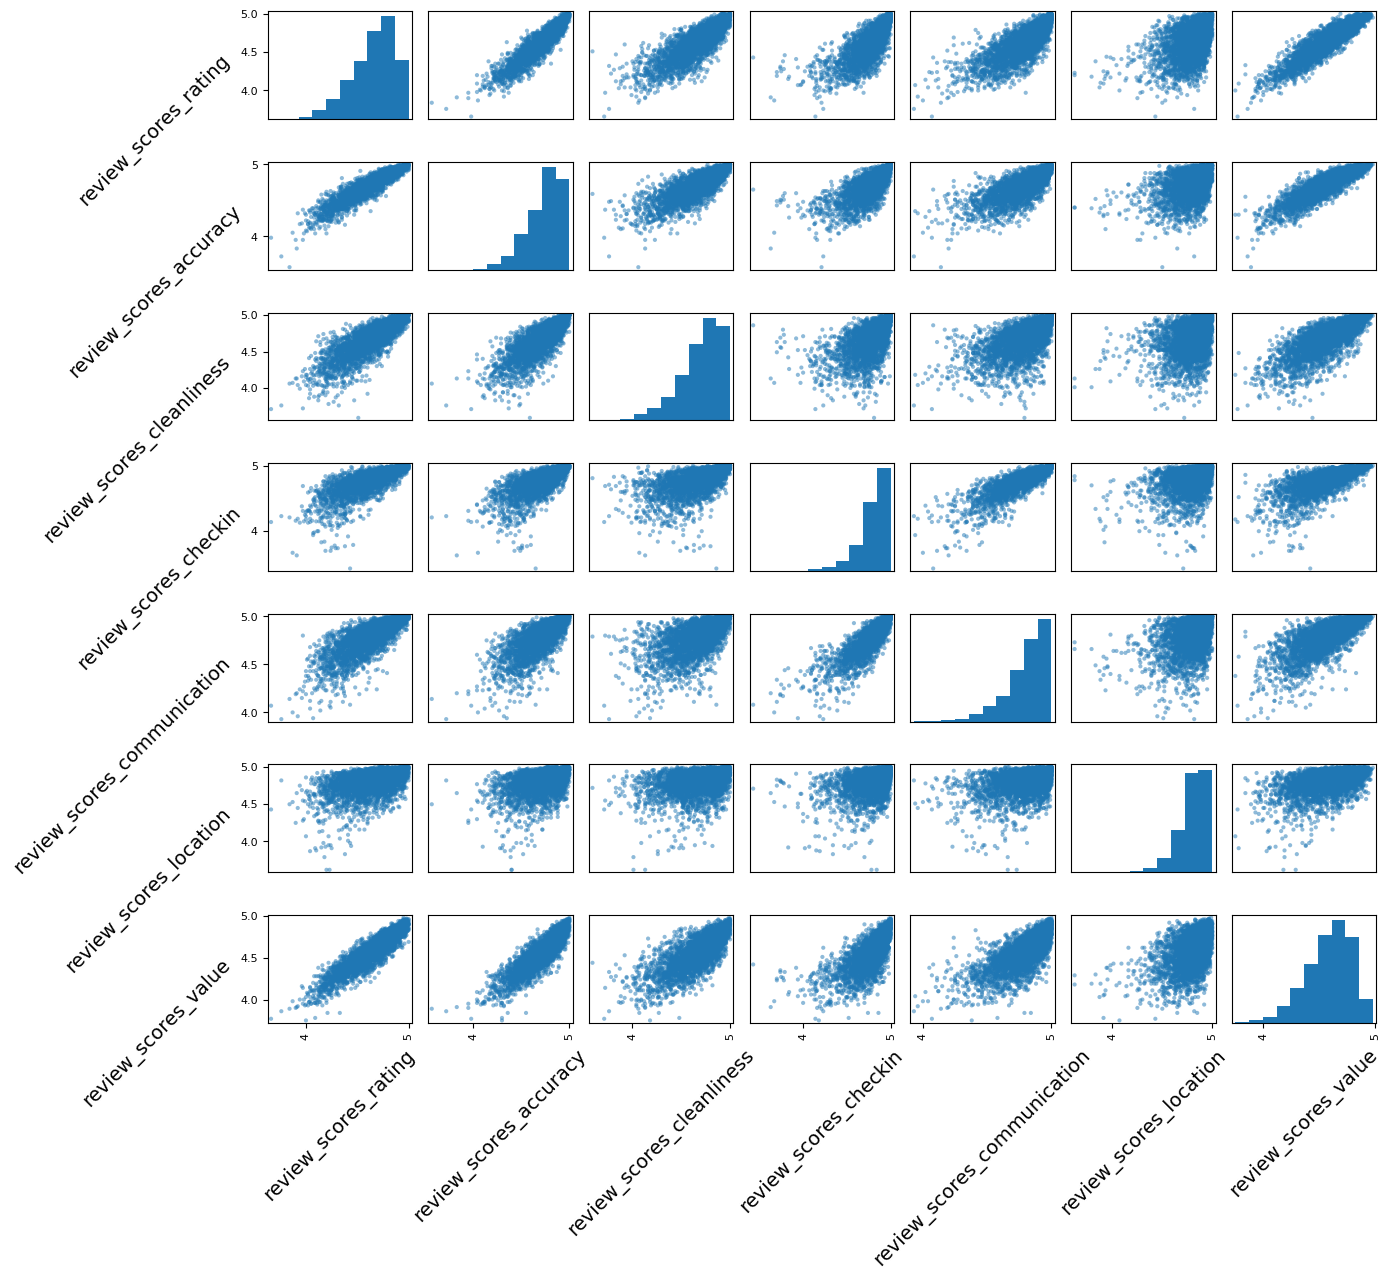

In [18]:
import pandas.plotting as pd_plotting
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

attributes = outpus_types.copy()
#attributes.append('average_value_per_listing_id')
#attributes.append('host_listings_count')
corr_matrix = filtered_insights[attributes].corr()
corr_matrix["review_scores_rating"].sort_values(ascending=False)
display(corr_matrix["review_scores_rating"].sort_values(ascending=False))
#scatter_matrix(filtered_insights_25[attributes], figsize=(17, 15), diagonal='hist',)
#save_fig("scatter_matrix_plot")

scatter_matrix_plot = pd_plotting.scatter_matrix(filtered_insights[attributes], figsize=(14, 13), diagonal='hist')
for ax in scatter_matrix_plot.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
#plt.savefig("images/score_correlations.png")
plt.show()


From this, we can extract that the three most positively coorelated scores to the global score are: accuracy, value and cleanness. That means that one has to tell the truth, give a good price and keep the accomodation clean. We can also see that the location is the least coorrelated of the scores to the global score wich is very interesting and nice to know if you already have an accomodation, because it means that you can do things to improve your valuation.

In [28]:
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")
values_to_check = ['average_value_per_listing_id','host_listings_count',['average_value_per_listing_id','host_listings_count'],""]
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
model_dict = {}

model,A,B,results_df = mod_maker.load_rf_model(filtered_insights,"Location_full",False)
A_final = pd.concat([A,B['review_scores_rating']],axis = 1)
corr_matrix = A_final.corr()
corr_matrix["review_scores_rating"].sort_values(ascending=False)
top_25 = corr_matrix["review_scores_rating"].sort_values(ascending=False).head(25)
display(top_25)

correlated_features = top_25[abs(top_25) > 0.2].index.tolist()


-----------------------------Model Found-----------------------------

,Model,Score type,R^2,MSE
0,RF >review_scores_ratingrevi,review_scores_rating,0.534983,0.021363
1,RF >review_scores_accuracyrevi,review_scores_accuracy,0.444573,0.017927
2,RF >review_scores_cleanlinessrevi,review_scores_cleanliness,0.359660,0.030436
3,RF >review_scores_checkinrevi,review_scores_checkin,0.658195,0.012178
4,RF >review_scores_communicationrevi,review_scores_communication,0.571922,0.012088
5,RF >review_scores_locationrevi,review_scores_location,0.648902,0.008885
6,RF >review_scores_valuerevi,review_scores_value,0.522727,0.019110
7,RF >location_fullrevi,review_scores_rating,0.523823,0.021876
8,RF >location_fullrevi,review_scores_accuracy,0.455990,0.017558
9,RF >location_fullrevi,review_scores_cleanliness,0.366046,0.030133


----------------------------Model Loaded-----------------------------

review_scores_rating          1.000000
host_is_superhost             0.477238
Extra pillows and blankets    0.265819
soap                          0.248982
First aid kit                 0.223227
Room-darkening shades         0.219025
Carbon monoxide alarm         0.209539
books                         0.206963
Smoke alarm                   0.195307
parking                       0.193608
number_of_reviews             0.191414
Luggage dropoff allowed       0.189324
Hangers                       0.188925
Host greets you               0.188835
shampoo                       0.185583
Wine glasses                  0.183229
Private patio or balcony      0.178871
Baby                          0.167305
Fire extinguisher             0.165506
Cooking basics                0.160284
Hot water                     0.151622
chair                         0.145373
conditioner                   0.139572
Dining table                  0.138649
Laundromat nearby             0.134422
Name: review_scores_ratin

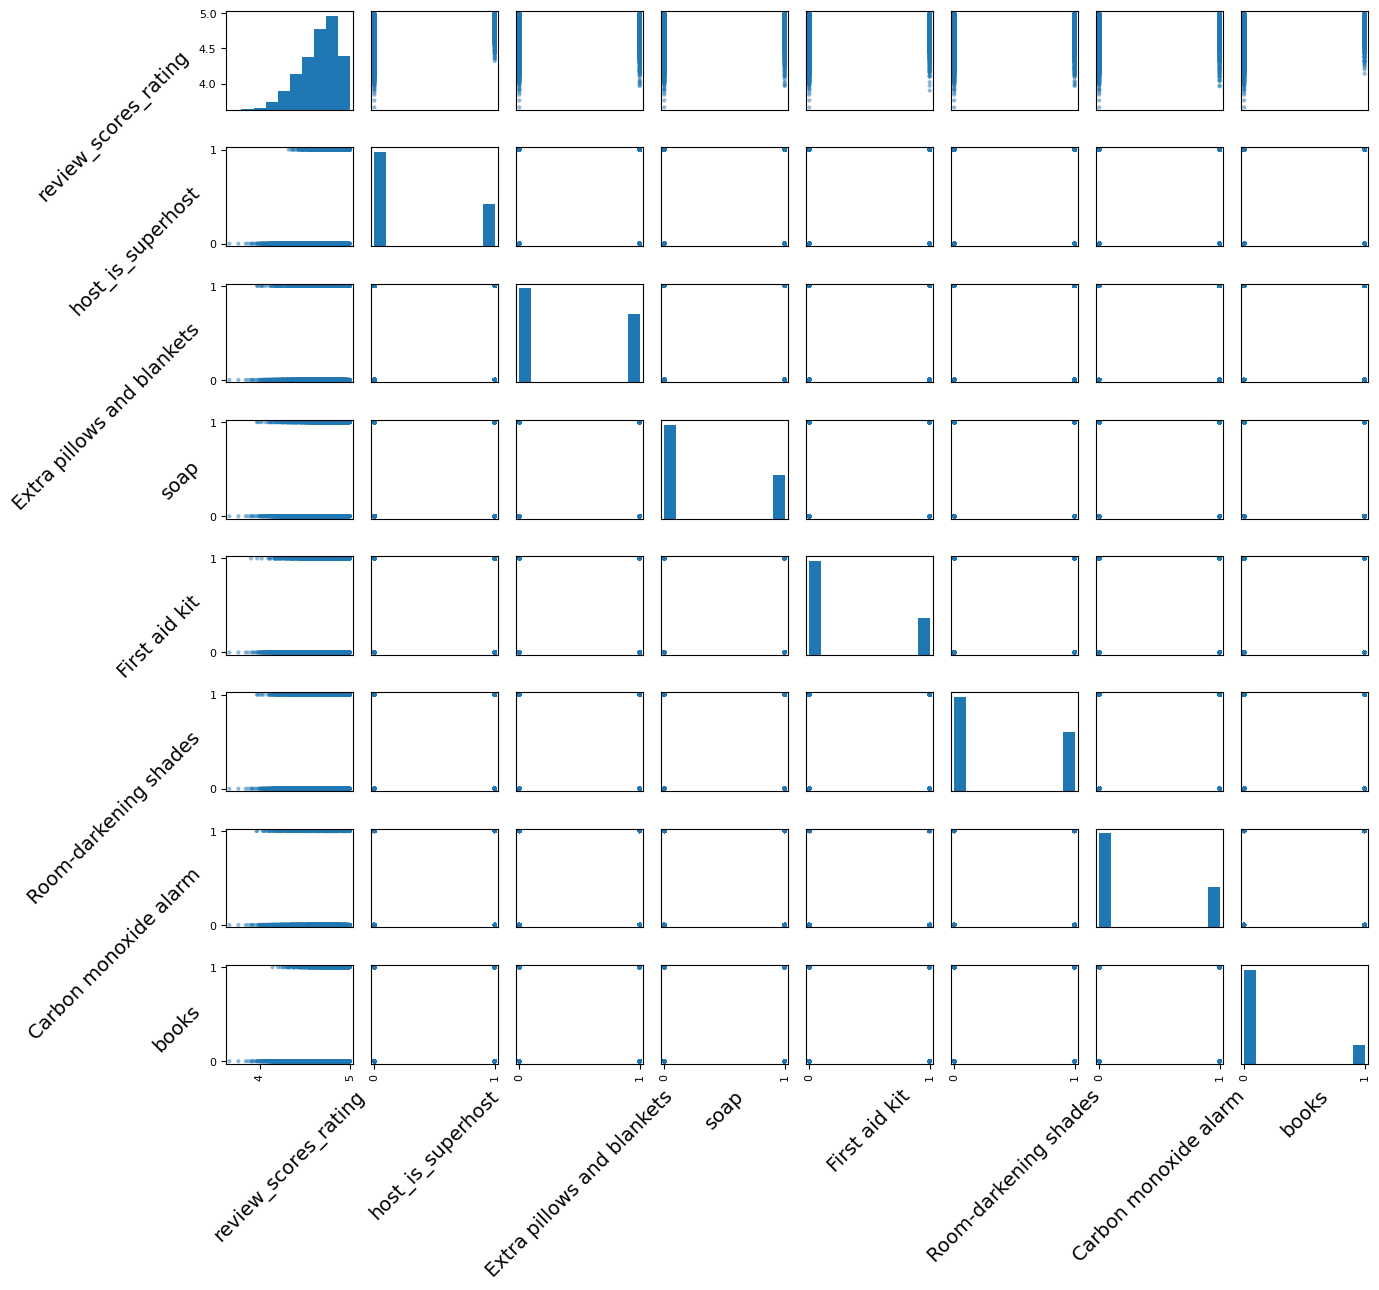

In [29]:
scatter_matrix_plot = pd_plotting.scatter_matrix(A_final[correlated_features], figsize=(14, 13), diagonal='hist')
for ax in scatter_matrix_plot.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.savefig("images/attribute_correlations.png")
plt.show()

In [45]:
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")
A,B = data_processer.bdd_premodel(filtered_insights,recalculate = False,num_min_reviews=50)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

In [46]:
def print_atri_corr_2(A_final,corr_features,name = "rating_corr"):
    scatter_matrix_plot = scatter_matrix(A_final[corr_features], figsize=(14, 13), diagonal='hist')

    for i, ax_row in enumerate(scatter_matrix_plot):
        for j, ax in enumerate(ax_row):
            if i != 0:
                ax.set_visible(False)
            else:
                ax.xaxis.label.set_rotation(45)
                ax.yaxis.label.set_rotation(0)
                ax.yaxis.label.set_ha('right')
                ax.get_xaxis().set_visible(True)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(f"images/{name}2.png")
    plt.show()

def print_all_corr_2(bdd):
    outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]   
    A,B = data_processer.bdd_premodel(bdd,recalculate = False,num_min_reviews=50)
    
    for i in outpus_types:
        A_final = pd.concat([A,A_euc,B[i]],axis = 1)
        corr_matrix = A_final.corr()
        corr_matrix[i].sort_values(ascending=True)
        top_25 = corr_matrix[i].sort_values(ascending=True).head(11)
        display(top_25)
        correlated_features = top_25[abs(top_25) > 0.2].index.tolist()
        #print_atri_corr_2(A_final,correlated_features,i)
    #display(top_25)
    

# Assuming filtered_insights, A_euc, and data_processer are defined
results_df = print_all_corr_2(filtered_insights)
display(results_df)


filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")
print_all_corr_2(filtered_insights)
    

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

calculated_host_listings_count                -0.371117
calculated_host_listings_count_entire_homes   -0.364956
host_total_listings_count                     -0.345418
host_listings_count                           -0.336139
Smart lock                                    -0.230560
availability_90                               -0.186307
availability_365                              -0.164918
availability_30                               -0.164446
availability_60                               -0.163653
Patio or balcony                              -0.140038
beds                                          -0.138527
Name: review_scores_rating, dtype: float64

calculated_host_listings_count                -0.351259
calculated_host_listings_count_entire_homes   -0.344780
host_total_listings_count                     -0.329222
host_listings_count                           -0.319949
Smart lock                                    -0.218800
availability_90                               -0.209748
availability_30                               -0.194199
availability_60                               -0.188584
availability_365                              -0.182244
beds                                          -0.163791
first_review                                  -0.146242
Name: review_scores_accuracy, dtype: float64

calculated_host_listings_count                -0.257078
calculated_host_listings_count_entire_homes   -0.252917
host_total_listings_count                     -0.248368
host_listings_count                           -0.235672
Smart lock                                    -0.152580
availability_90                               -0.141041
beds                                          -0.139253
availability_30                               -0.136800
Patio or balcony                              -0.127975
availability_60                               -0.126246
availability_365                              -0.124157
Name: review_scores_cleanliness, dtype: float64

calculated_host_listings_count                -0.523042
calculated_host_listings_count_entire_homes   -0.513166
host_listings_count                           -0.450750
host_total_listings_count                     -0.444760
Smart lock                                    -0.327110
availability_90                               -0.216321
first_review                                  -0.188903
Patio or balcony                              -0.185824
availability_365                              -0.180574
availability_60                               -0.178305
Self check-in                                 -0.176955
Name: review_scores_checkin, dtype: float64

calculated_host_listings_count                -0.398579
calculated_host_listings_count_entire_homes   -0.387187
host_total_listings_count                     -0.360103
host_listings_count                           -0.350855
Smart lock                                    -0.234062
first_review                                  -0.222287
availability_90                               -0.213231
availability_60                               -0.185783
availability_30                               -0.174829
availability_365                              -0.155375
Air conditioning                              -0.154186
Name: review_scores_communication, dtype: float64

Eucld_Plaça catalunya   -0.475496
Eucld_Plaça catalunya   -0.475496
Eucld_Catedral BCN      -0.469829
Eucld_Catedral BCN      -0.469829
Eucld_Liceu             -0.438970
Eucld_Liceu             -0.438970
Eucld_Ciutadella        -0.438555
Eucld_Ciutadella        -0.438555
Eucld_Raval             -0.392909
Eucld_Raval             -0.392909
Eucld_La Pedrera        -0.377050
Name: review_scores_location, dtype: float64

calculated_host_listings_count                -0.378613
calculated_host_listings_count_entire_homes   -0.376135
host_total_listings_count                     -0.365381
host_listings_count                           -0.353215
availability_90                               -0.264046
Smart lock                                    -0.242609
availability_60                               -0.231222
availability_30                               -0.227932
has_license                                   -0.226373
availability_365                              -0.221895
property_type_Entire rental unit              -0.214063
Name: review_scores_value, dtype: float64

None

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

calculated_host_listings_count                -0.371117
calculated_host_listings_count_entire_homes   -0.364956
host_total_listings_count                     -0.345418
host_listings_count                           -0.336139
Smart lock                                    -0.230560
availability_90                               -0.186307
availability_365                              -0.164918
availability_30                               -0.164446
availability_60                               -0.163653
Patio or balcony                              -0.140038
beds                                          -0.138527
Name: review_scores_rating, dtype: float64

calculated_host_listings_count                -0.351259
calculated_host_listings_count_entire_homes   -0.344780
host_total_listings_count                     -0.329222
host_listings_count                           -0.319949
Smart lock                                    -0.218800
availability_90                               -0.209748
availability_30                               -0.194199
availability_60                               -0.188584
availability_365                              -0.182244
beds                                          -0.163791
first_review                                  -0.146242
Name: review_scores_accuracy, dtype: float64

calculated_host_listings_count                -0.257078
calculated_host_listings_count_entire_homes   -0.252917
host_total_listings_count                     -0.248368
host_listings_count                           -0.235672
Smart lock                                    -0.152580
availability_90                               -0.141041
beds                                          -0.139253
availability_30                               -0.136800
Patio or balcony                              -0.127975
availability_60                               -0.126246
availability_365                              -0.124157
Name: review_scores_cleanliness, dtype: float64

calculated_host_listings_count                -0.523042
calculated_host_listings_count_entire_homes   -0.513166
host_listings_count                           -0.450750
host_total_listings_count                     -0.444760
Smart lock                                    -0.327110
availability_90                               -0.216321
first_review                                  -0.188903
Patio or balcony                              -0.185824
availability_365                              -0.180574
availability_60                               -0.178305
Self check-in                                 -0.176955
Name: review_scores_checkin, dtype: float64

calculated_host_listings_count                -0.398579
calculated_host_listings_count_entire_homes   -0.387187
host_total_listings_count                     -0.360103
host_listings_count                           -0.350855
Smart lock                                    -0.234062
first_review                                  -0.222287
availability_90                               -0.213231
availability_60                               -0.185783
availability_30                               -0.174829
availability_365                              -0.155375
Air conditioning                              -0.154186
Name: review_scores_communication, dtype: float64

Eucld_Plaça catalunya   -0.475496
Eucld_Plaça catalunya   -0.475496
Eucld_Catedral BCN      -0.469829
Eucld_Catedral BCN      -0.469829
Eucld_Liceu             -0.438970
Eucld_Liceu             -0.438970
Eucld_Ciutadella        -0.438555
Eucld_Ciutadella        -0.438555
Eucld_Raval             -0.392909
Eucld_Raval             -0.392909
Eucld_La Pedrera        -0.377050
Name: review_scores_location, dtype: float64

calculated_host_listings_count                -0.378613
calculated_host_listings_count_entire_homes   -0.376135
host_total_listings_count                     -0.365381
host_listings_count                           -0.353215
availability_90                               -0.264046
Smart lock                                    -0.242609
availability_60                               -0.231222
availability_30                               -0.227932
has_license                                   -0.226373
availability_365                              -0.221895
property_type_Entire rental unit              -0.214063
Name: review_scores_value, dtype: float64

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

review_scores_location                                          1.000000
neighbourhood_cleansed_la Dreta de l'Eixample                   0.283443
neighbourhood_group_cleansed_Eixample                           0.279443
host_is_superhost                                               0.202089
neighbourhood_cleansed_Sant Pere, Santa Caterina i la Ribera    0.171329
Name: review_scores_location, dtype: float64

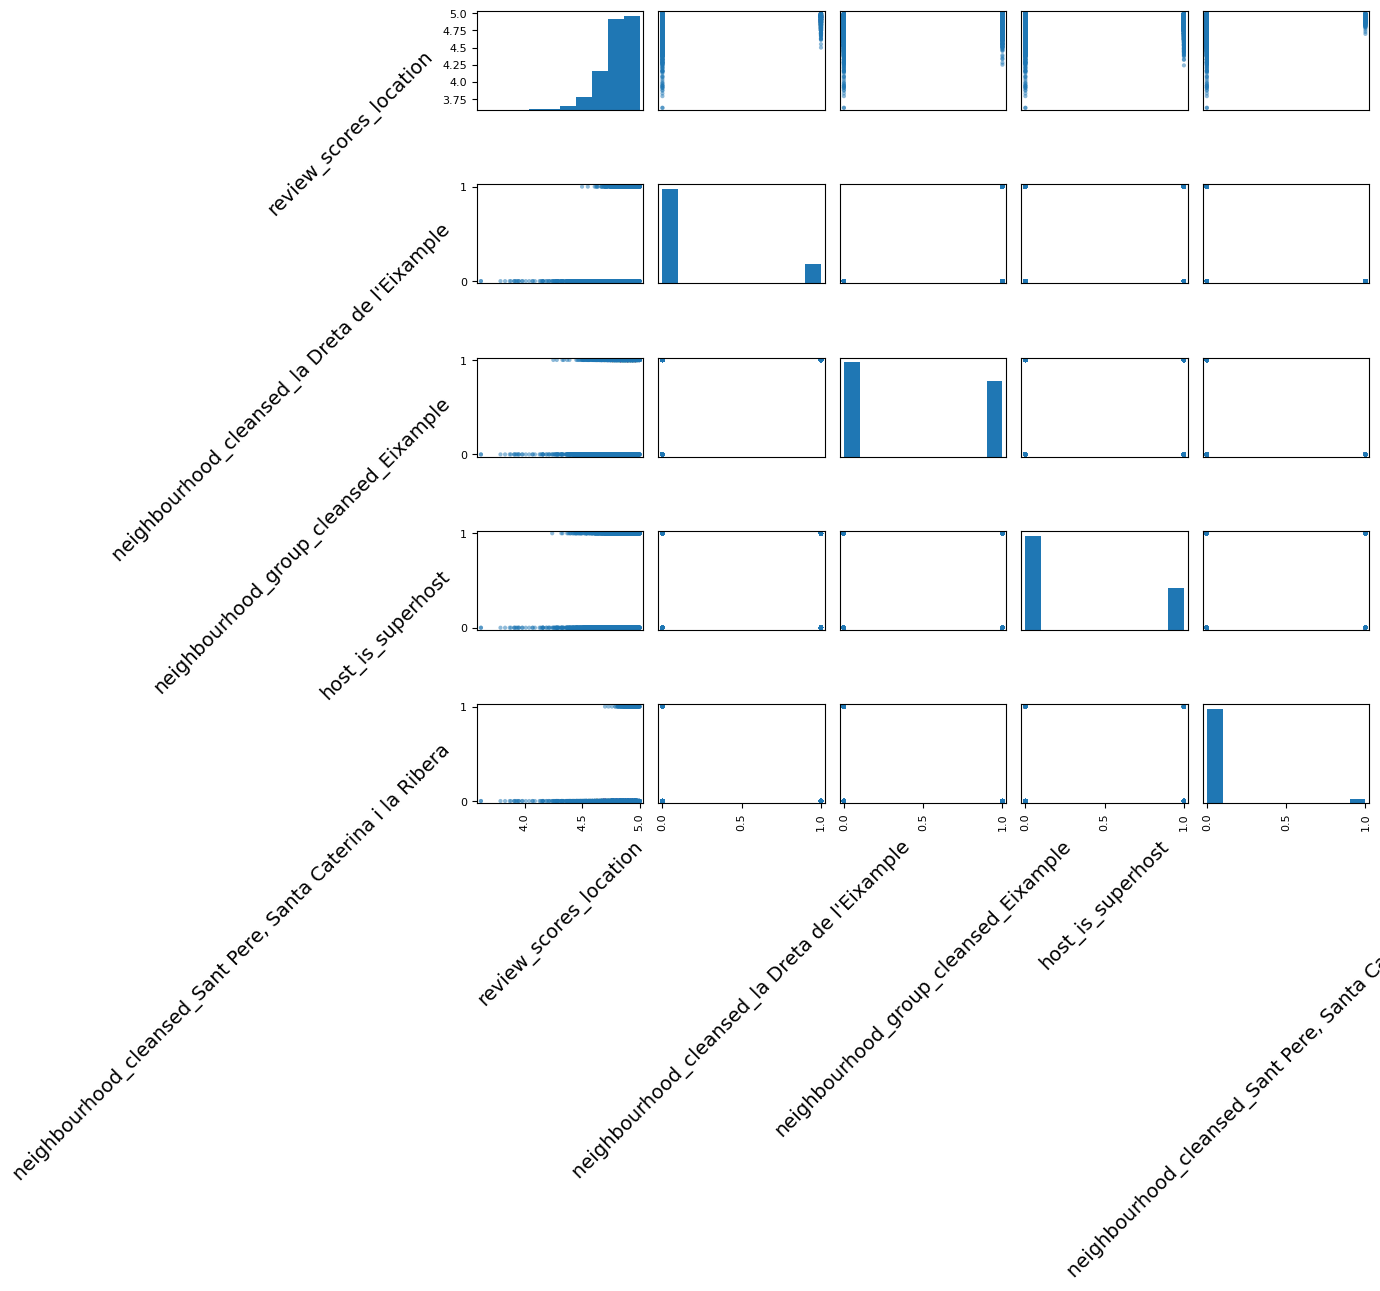

In [51]:
filtered_insights = pd.read_csv("bdd_barcelona/processed/Test-5/insight_with_GPT_Landmark_50.csv")
values_to_check = ['average_value_per_listing_id','host_listings_count',['average_value_per_listing_id','host_listings_count'],""]
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
model_dict = {}

A_euc = insights[eucl_list].copy()

A,B = data_processer.bdd_premodel(filtered_insights,recalculate = False,num_min_reviews=50)
A_final = pd.concat([A,B['review_scores_location']],axis = 1)
corr_matrix = A_final.corr()
corr_matrix["review_scores_location"].sort_values(ascending=False)
top_25 = corr_matrix["review_scores_location"].sort_values(ascending=False).head(5)
display(top_25)

correlated_features = top_25[abs(top_25) > 0.15].index.tolist()

scatter_matrix_plot = pd_plotting.scatter_matrix(A_final[correlated_features], figsize=(14, 13), diagonal='hist')
for ax in scatter_matrix_plot.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.savefig("images/attribute_correlations.png")
plt.show()

In [54]:
A,B = data_processer.bdd_premodel(filtered_insights,recalculate = False,num_min_reviews=50)
bdd_final = pd.concat([A,B],axis = 1)
display(bdd_final.head(2))
bdd_final.to_csv("bdd_barcelona/processed/Test-5/insight_final.csv", index=False)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

,neighbourhood_group_cleansed_Ciutat Vella,neighbourhood_group_cleansed_Eixample,neighbourhood_group_cleansed_Gràcia,neighbourhood_group_cleansed_Horta-Guinardó,neighbourhood_group_cleansed_Les Corts,neighbourhood_group_cleansed_Nou Barris,neighbourhood_group_cleansed_Sant Andreu,neighbourhood_group_cleansed_Sant Martí,neighbourhood_group_cleansed_Sants-Montjuïc,neighbourhood_group_cleansed_Sarrià-Sant Gervasi,...,beach,chair,crib,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,4.77,4.93,4.88,4.94,4.99,4.61,4.63
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,4.43,4.43,4.45,4.86,4.85,4.86,4.52
